# **Predicting Machine Failure with Deep Learning**

**Data Source**: UCI - AI4I 2020 Predictive Maintenance Dataset

**Link**: https://archive.ics.uci.edu/dataset/601/ai4i2020+predictive+maintenance+dataset

**Group**: 2

**Members**:
- AbdulQudus Adebogun - 20241355
- Hagar Fisher - 20241607
- Md Mijanul Haque - TBA
- Patricia Fabiawari Agha - TBA

## **1. Project Description**

### 1.1. Project Overview

This project focuses on predicting machine failure in an industrial manufacturing setting using the AI4I 2020 Predictive Maintenance Dataset. The task is framed as a binary classification problem, where the goal is to determine whether a machine will fail during a given production cycle based on operational sensor data.

Machine failures in the dataset arise from interactions between thermal conditions, mechanical load, and cumulative tool wear, creating nonlinear patterns that are well suited to deep learning approaches. The dataset is also highly imbalanced, with failures representing approximately 3.4% of all observations, reflecting realistic predictive maintenance scenarios.

### 1.2. Project Aims

The main objectives of this project are to:
- Explore and understand the operational data associated with machine failures
- Perform feature engineering to expose interaction-driven failure patterns
- Develop and evaluate a deep learning model for failure risk prediction
- Assess model performance under severe class imbalance using appropriate metrics

### 1.3. Data Overview

The AI4I 2020 Predictive Maintenance Dataset contains 10,000 manufacturing process records, each representing a single production cycle with associated sensor readings, operating conditions, and failure labels. The dataset includes both continuous numerical variables and categorical production attributes, as well as detailed binary indicatrs for different machine failure mechanisms. All values are fully observed, and the dataset is clean and structured for modeling.

</br>

**Feature Definitions**:
- **UDI**: A Unique identifier ranging from 1 to 10000
- **Product ID**: A product-specific code containing a letter that represents quality level (L = low, 50%; M = medium, 30%; H = high, 20%) followed by a serial number.
- **Type**: The categorical product quality level, extracted from Product ID.
- **Air temperature [K]**: Generated using a random walk process later normalized to ~300 K with a standard deviation of 2 K.
- **Process temperature [K]**: Also generated using a normalised random walk process to a standard deviation of 1 K, and ensured to always be ~10 K above air temperature.
- **Rotational speed [rpm]**: Derived from a base power of 2860 W and overlaid with normally distributed noise.
- **Torque [Nm]**: Normally distributed around 40 Nm (σ = 10) with a Ïƒ = 10 Nm and no negative values.
- **Tool wear [min]**: Accumulates tool usage, with wear increments depending on product quality level (H +5 min, M +3 min, L +2 min).
- **Machine failure**: The binary target variable indicating whether the machine failed (1) or not (0) during the process cycle.

</br>

Machine failure is determined by five independent failure mechanisms described below. A machine failure is recorded whenever at least one failure mode is triggered, reflecting industrial settings where breakdowns arise from multiple interacting causes rather than a single fault.

**Failure Mode Features**:
- **Tool Wear Failure (TWF)**: Occurs when tool wear exceeds a randomly assigned failure threshold between 200-240 minutes (120 occurrences: 69 replacements, 51 failures).
- **Heat Dissipation Failure (HDF)**: Occurs when the temperature difference between process and air is below 8.6 K and rotational speed is below 1380 rpm (115 occurrences).
- **Power Failure (PWF)**: Occurs when the mechanical power (torque x angular velocity) falls outside the safe operating range of 3500-9000 W (95 occurrences).
- **Overstrain Failure (OSF)**: Happens when torque x tool wear exceeds quality-dependent thresholds (98 occurrences):
  - 11,000 minNm for L
  - 12,000 minNm for M
  - 13,000 minNm for H
- **Random Failures (RNF)**: A rare probabilistic failure mode (0.1% chance per record), independent of process parameters (5 occurrences).

Because machine failures result from hidden combinations of thermal, mechanical, and stochastic conditions, the task presents a realistic and challenging predictive maintenance problem. This makes the dataset particularly well-suited for advanced modeling approaches such as Deep Learning, and it provides a strong foundation for exploratory analysis, feature engineering, and model interpretation in the sections that follow.



## **2. Environment Set-Up**

### 2.1. Load Libraries

In [ ]:
# Drive Set-up
from google.colab import drive

# Basic Python utilities
import numpy as np
import pandas as pd
import math
import textwrap

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical utilities
from scipy.stats import chi2_contingency, pearsonr, pointbiserialr

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, fbeta_score, roc_auc_score, average_precision_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras import regularizers

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Future Warning
import warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

### 2.2. Helper Functions

In [ ]:
def plot_numeric_distributions(df, columns):
    """
    Plots histograms for multiple continuous variables with full
    summary statistics tables under each plot.

    Parameters:
    - df : pandas.DataFrame = The dataset containing the continuous variables.
    - columns : list = List of continuous variable names to plot.
    """
    cols_per_row = 2
    rows = math.ceil(len(columns) / cols_per_row)

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 5.5 * rows))
    axes = axes.flatten()

    table_y_offset = -0.6

    for i, col in enumerate(columns):
        ax = axes[i]
        sns.histplot(df[col], bins=25, color="#96B2CE", edgecolor="black", kde=True, ax=ax)
        ax.set_title(f"{col} Distribution", fontsize=11, weight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

        # Summary stats
        desc = df[col].describe()
        skew = df[col].skew()
        kurt = df[col].kurt()

        full_stats = pd.Series({
            'count': desc['count'],
            'mean': desc['mean'],
            'std':  desc['std'],
            'min':  desc['min'],
            '25%':  desc['25%'],
            '50%':  desc['50%'],
            '75%':  desc['75%'],
            'max':  desc['max'],
            'skew': skew,
            'kurt': kurt
        })

        vals = np.round(full_stats.values, 2).reshape(1, -1)
        labels = list(full_stats.index)

        table = ax.table(
            cellText=vals,
            colLabels=labels,
            cellLoc='center',
            loc='bottom',
            bbox=[0.0, table_y_offset, 1, 0.3]
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.05, 0.9)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(hspace=1.0, wspace=0.2, bottom=0.0)
    plt.show()

In [ ]:
def plot_bivariate_numeric(df, cols, target='Machine failure'):
    """
    Creates KDE + Boxplot + Summary Table for each numeric variable against the binary target.
    Works for 0/1 targets and automatically calculates summary statistics.

    Parameters:
        df (DataFrame): dataset
        numeric_cols (list): list of numeric column names
        target (str): binary target variable (0/1)
    """

    import matplotlib.gridspec as gridspec

    for var in numeric_cols:

        fig = plt.figure(figsize=(12, 7))
        gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])
        gs.update(wspace=0.25, hspace=0.35)

        # -----------------------
        # KDE Plot
        # -----------------------
        ax0 = plt.subplot(gs[0, 0])
        sns.kdeplot(
            data=df, x=var, hue=target, fill=True, common_norm=False,
            palette=['#A8C5E6', '#E6A8A8'], alpha=0.5
        )
        ax0.set_title(f"{var} Distribution by {target}", fontsize=12, weight='bold')
        ax0.set_xlabel(var)
        ax0.set_ylabel("Density")

        # -----------------------
        # Boxplot
        # -----------------------
        ax1 = plt.subplot(gs[0, 1])
        sns.boxplot(
            data=df, x=target, y=var,
            palette=['#A8C5E6', '#E6A8A8'], width=0.6
        )
        ax1.set_title(f"{var} by {target}", fontsize=12, weight='bold')
        ax1.set_xlabel("")
        ax1.set_ylabel("")

        # -----------------------
        # Summary Table
        # -----------------------
        ax_table = plt.subplot(gs[1, :])
        ax_table.axis('off')

        summary = (
            df.groupby(target)[var]
            .agg([
                'count',
                'mean',
                ('p25', lambda x: x.quantile(0.25)),
                ('median', 'median'),
                ('p75', lambda x: x.quantile(0.75)),
                'min',
                'max'
            ])
            .round(2)
        )

        table = ax_table.table(
            cellText=summary.values,
            rowLabels=[f"{target}={i}" for i in summary.index],
            colLabels=summary.columns,
            cellLoc='center',
            loc='center'
        )

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.2)

        # -----------------------
        # Title
        # -----------------------
        plt.suptitle(
            f"{var}: Distribution, Comparison, and Summary",
            fontsize=14, weight='bold'
        )

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [ ]:
def plot_categorical_distributions(df, columns):
    cols_per_row = 2
    rows = math.ceil(len(columns) / cols_per_row)

    # Reduce figure height per row to avoid giant vertical spacing
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 4.5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]

        unique_vals = df[col].nunique()

        # Handle high-cardinality variables
        if unique_vals > 15:
            top10 = df[col].value_counts().nlargest(10).index
            df_plot = df[df[col].isin(top10)]
            order = top10
            subtitle = " (Top 10)"
        else:
            df_plot = df
            order = sorted(df[col].unique()) if pd.api.types.is_numeric_dtype(df[col]) else None
            subtitle = ""

        sns.countplot(
            x=col,
            data=df_plot,
            order=order,
            palette="Blues",
            ax=ax,
            legend=False
        )

        ax.set_title(f"{col} Distribution", fontsize=13, weight='bold')
        ax.set_xlabel(f"{col}{subtitle}", fontsize=11, weight='bold')
        ax.set_ylabel("Count", fontsize=10)

        # Wrap xticks
        labels = [tick.get_text() for tick in ax.get_xticklabels()]
        wrapped = [
            "\n".join(textwrap.wrap(label, width=12)) if len(label) > 12 else label
            for label in labels
        ]
        ax.set_xticks(range(len(wrapped)))
        ax.set_xticklabels(
            wrapped,
            rotation=40 if unique_vals > 6 else 0,
            ha='right'
        )

        # Percent labels
        total = len(df)
        for container in ax.containers:
            if hasattr(container, "datavalues"):
                perc = [f"{(v / total) * 100:.2f}%" for v in container.datavalues]
                ax.bar_label(container, labels=perc, fontsize=8, padding=2)

    # Remove unused axes
    for j in range(len(columns), len(axes)):
        axes[j].set_visible(False)

    # Spacing
    plt.tight_layout(pad=1.5, h_pad=2.0, w_pad=1.0)
    plt.show()


In [ ]:
def plot_bivariate_categorical(df, columns, target_col='Machine failure'):
    """
    Plots failure rate (%) for each categorical/binary feature.
    Arranges plots in a grid with 2 columns per row.
    """

    # Overall failure rate in %
    overall_failure = (df[target_col] == 1).mean() * 100

    n_features = len(columns)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axes = axes.flatten()

    for ax, feature in zip(axes, columns):

        # Normalize rows to get percent failure per category
        failure_by_var = (
            pd.crosstab(df[feature], df[target_col], normalize='index') * 100
        )

        # Ensure both 0 and 1 columns exist
        if 0 not in failure_by_var.columns:
            failure_by_var[0] = 0.0
        if 1 not in failure_by_var.columns:
            failure_by_var[1] = 0.0

        failure_by_var = failure_by_var[[0, 1]]  # order columns

        failure_by_var.plot(
            kind='bar',
            ax=ax,
            color=['#A8C5E6', '#E6A8A8'],  # no-failure, failure
            edgecolor='black',
            width=0.7
        )

        ax.set_title(f'Failure Rate by {feature}', fontsize=13, weight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Percentage (%)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Reference line for overall failure rate
        ax.axhline(y=overall_failure, color='red', linestyle='--',
                   linewidth=1.5, alpha=0.7, label='Overall Failure Rate')

        # Annotate bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', fontsize=8)

    # Hide unused subplots
    for j in range(len(columns), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


### 2.3. Mount Google Drive in Colab

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### 2.4. Load Dataset

In [ ]:
file_path = "/content/drive/My Drive/DLNN Project/data/ai4i2020.csv"

df = pd.read_csv(file_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## **3. Exploratory Data Analysis**

### 3.1. Initial Inspection

In [ ]:
print("Shape:", df.shape)
print("")
df.info()
print("")
df.describe().T

Shape: (10000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: 

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


**Dataset Shape**:
- The dataset contains 10,000 rows and 14 columns.
- This size is ideal for deep learning experimentation: large enough for training, small enough for efficient computation.

</br>

**Missing Values**:
- All 14 columns show complete data (no missing values).
- This simplifies preprocessing since no imputation is required.

</br>

**Data Types** - The dataset is mostly numeric, which is advantageous for machine learning models and allows straightforward scaling and preprocessing:
- Numerical features (12 total):
  - 3 floating-point sensor measurements
  - 9 integer fields (operational features + failure indicators + index (UDI))
- Categorical features (2 total):
  - Type
  - Product ID -> `Drop`: redundant with type and has high cardinality

</br>

**Index Insights**:
- UDI -> `Index`: a unique identifier for each record
- It carries no predictive value but provides clean row indexing

</br>

**Target Variable Summary**:
- Machine failure has a mean of 0.0339, indicating 3.39% failures.
- Confirms that this is a highly imbalanced classification problem, typical of industrial fault detection tasks.

</br>

**Numerical Feature Ranges** - These distributions match the physics-based generation defined in the dataset documentation, confirming that the data is internally consistent:
- **Temperatures** fall within realistic industrial ranges (295-305 K for air, 306-314 K for process).
- **Rotational Speed** varies widely (1168-2886 rpm), showing the potential influence of operational load.
- **Torque** ranges from approx. 4-76 Nm, normally distributed as documented.
- **Tool wear** ranges from 0 to 253 minutes, consistent with gradual wear accumulation.

**Failure Mode Indicators** - All failure mode columns (TWF, HDF, PWF, OSF, RNF) are:
- Binary
- Extremely sparse (means between 0.0019 and 0.0115)
- This confirms:
  - Failures are rare events
  - Each failure mechanism contributes only a small number of positive examples
  - The model must learn from limited signal and strong imbalance

</br>

**Conclusion of Initial Inspection**:

The dataset is clean, complete, and well-structured. No missing values, correct data types, and all features fall within expected ranges based on the physics of the process. Because failures are rare and governed by underlying nonlinear relationships, this motivates both careful EDA and FE, and the use of models capable of capturing interaction effects.

### 3.2. Initial Clean-up

#### 3.2.1. Set UDI as Index

In [ ]:
# Verify all values are unique
df["UDI"].is_unique

True

In [ ]:
# Set UDI as the index
df = df.set_index("UDI")

#### 3.2.2. Check for Exact Duplicate Rows


In [ ]:
duplicate_rows = df.duplicated(keep=False)

print("Number of duplicate rows:", duplicate_rows.sum())

Number of duplicate rows: 0


#### 3.2.3. Check Product ID and Type are Matching and Drop Irrelevant Variables

In [ ]:
# Check that Product ID's categorical product quality label matches Type

# Extract the first letter from Product ID
df['Extracted_Type'] = df['Product ID'].str[0]

# Compare it with the provided Type column
mismatches = (df['Extracted_Type'] != df['Type']).sum()

print("Number of mismatches:", mismatches)
df[['Product ID', 'Type', 'Extracted_Type']].head()


Number of mismatches: 0


,Product ID,Type,Extracted_Type
UDI,,,
1,M14860,M,M
2,L47181,L,L
3,L47182,L,L
4,L47183,L,L
5,L47184,L,L


In [ ]:
# Drop Redundancies
df = df.drop(columns=['Product ID', 'Extracted_Type'])

# Re-inspect Data
print("Shape:", df.shape)
print("")
df.info()
print("")
df.describe().T


Shape: (10000, 12)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1015.6+ KB



,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.0,0.0,0.0,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.0,0.0,0.0,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.0,0.0,0.0,1.0
OSF,10000.0,0.00980,0.098514,0.0,0.0,0.0,0.0,1.0


After setting UDI as the index and removing the redundant Product ID column, the dataset now contains 10,000 rows and 12 features, including:
- 1 categorical feature (Type)
- 3 continuous numerical operational features
- 2 integer numerical operational features
- 1 binary target variable (Machine failure)
- 5 binary failure mode indicators (TWF, HDF, PWF, OSF, RNF)

This cleaned structure provides a solid foundation for deeper exploratory analysis, where we will examine distributions, relationships between operational variables, and the patterns leading to machine failure.

In [ ]:
# Groupings for Deeper EDA
target_col = 'Machine failure'

mode_indicators = [
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]

numeric_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

categoric_cols = [
    'Type'
]

### 3.3. Target Feature Analysis

Machine Failure Distribution:



,Count,Percentage (%)
Machine failure,,
0,9661,96.61
1,339,3.39


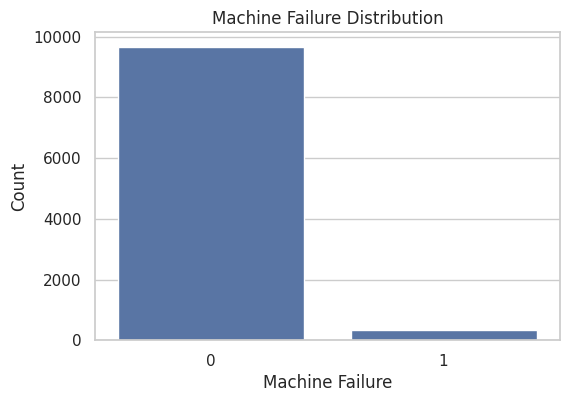

In [ ]:
# Table showing the count and percentage of each class
target_counts = df[target_col].value_counts()  # Count of each class
target_percent = (target_counts / len(df)) * 100        # Percentage of each class
target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_percent.round(2)
})

print("Machine Failure Distribution:\n")
display(target_summary)
print("")

# Distribution Plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x=target_col, order=target_counts.index)
plt.title("Machine Failure Distribution")
plt.xlabel("Machine Failure")
plt.ylabel("Count")
plt.show()

**Machine failure is a rare event (3.39%)**:
- Only 339 out of 10,000 records correspond to a failure.
- This reflects real industrial environments, where failures are infrequent but high-impact.
- will require stratified sampling strategy

</br>

**Implications for Binary Classification**:
- Because the dataset is highly imbalanced, a naïve model predicting "no failure" would achieve 96.6% accuracy without learning anything meaningful.
- False negatives (missed failures) are far more costly than false positives, so recall-oriented evaluation becomes crucial.
- Implication for evaluation:
  - Accuracy is **not** an appropriate metric.
  - We must evaluate performance using:
    - Precision
    - Recall (sensitivity to failures)
    - F1-score
    - ROC-AUC
    - Precision-Recall AUC (especially important for rare events)

</br>

**Preprocessing and Modeling Requirements**
- Because machine failures arise from combinations of operational conditions rather than single variables in isolation, the distinction between normal and failing cases is subtle and often nonlinear. This has important implications for the next stages of our workflow:
  - **Deeper exploratory Data Analysis** will help identify which relationships and interactions between features contribute most strongly to failure events
  - **Feature Engineering** will later incorporate domain knowledge from the physics-based failure mechanisms to construct more informative inputs for the model.
  - **Preprocessing** must prepare the input variables in a way that allows the model to recognize meaningful patterns, including scaling continuous features and encoding categorical variables appropriately.
  - **Model Development** must account for the strong class imbalance and leverage architectures capable of capturing nonlinear relationships, such as deep neural networks.

These requirements reinforce our choice of Deep Learning, which is better suited to capturing complex relationships than linear or shallow models.

</br>

> Our final model will use a single sigmoid output neuron and a class-weighted loss function to emphasize correct detection of failure cases.


### 3.4. Failure Mode Indicators Analysis

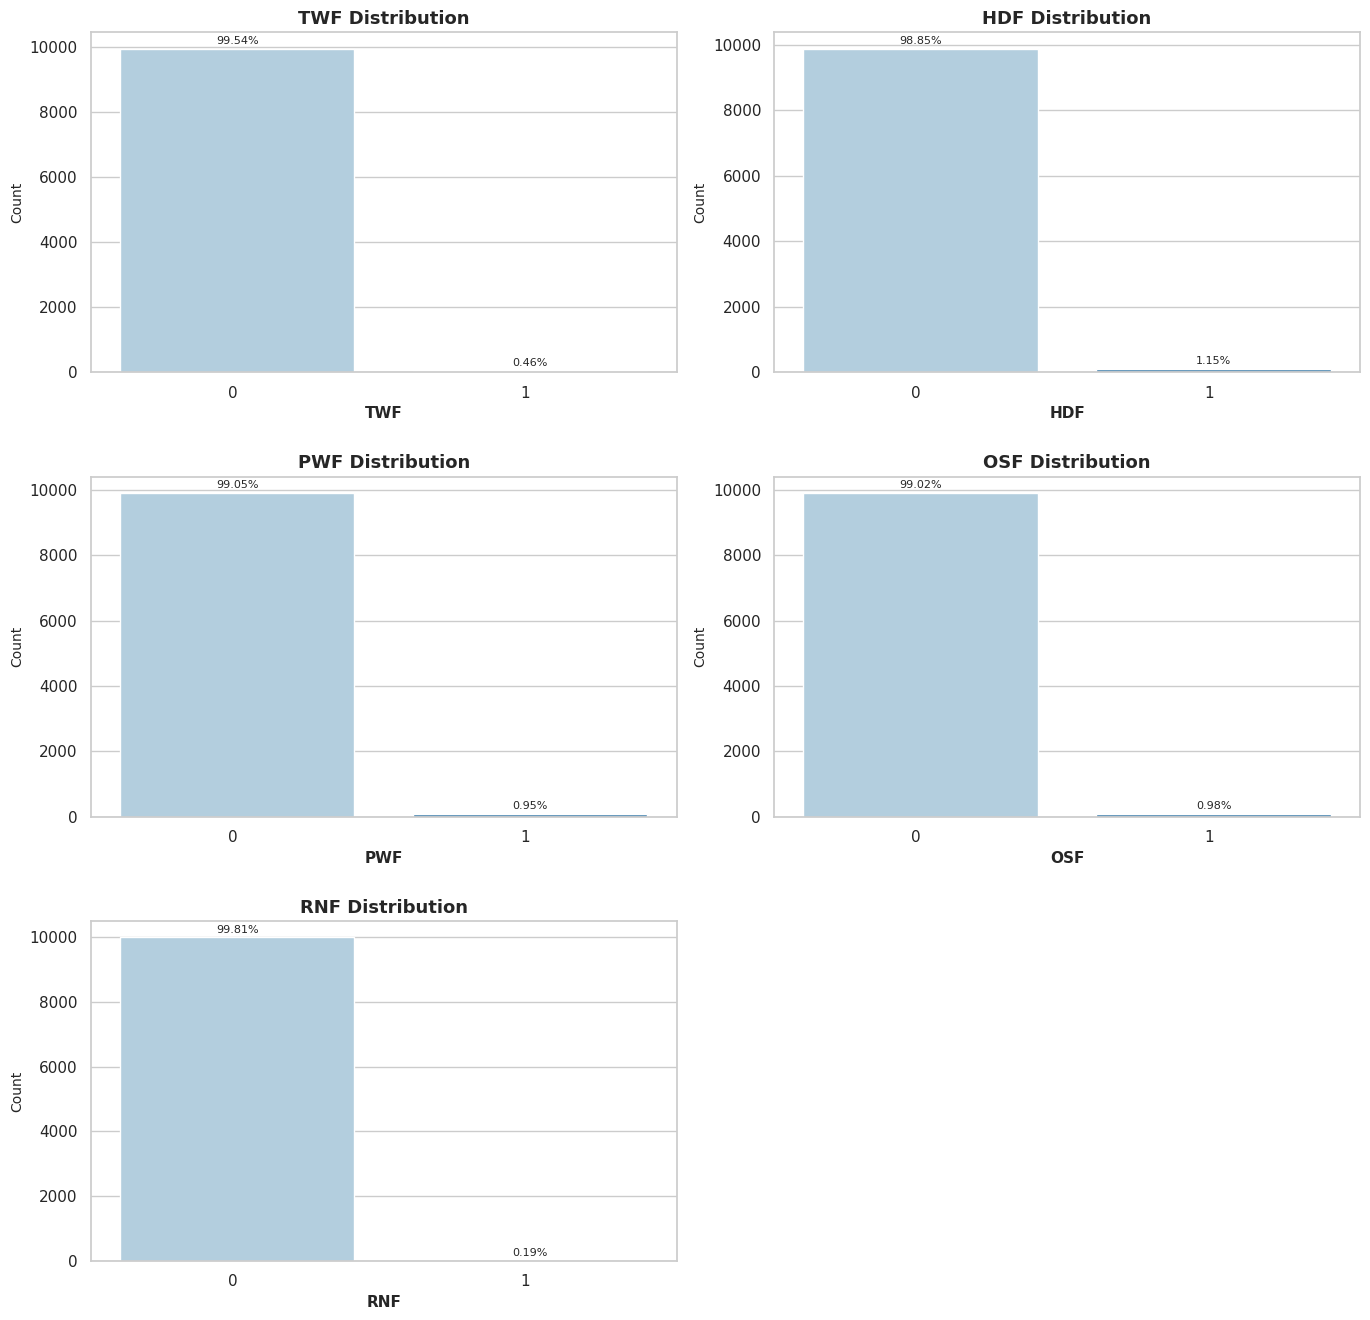

In [ ]:
plot_categorical_distributions(df, mode_indicators)

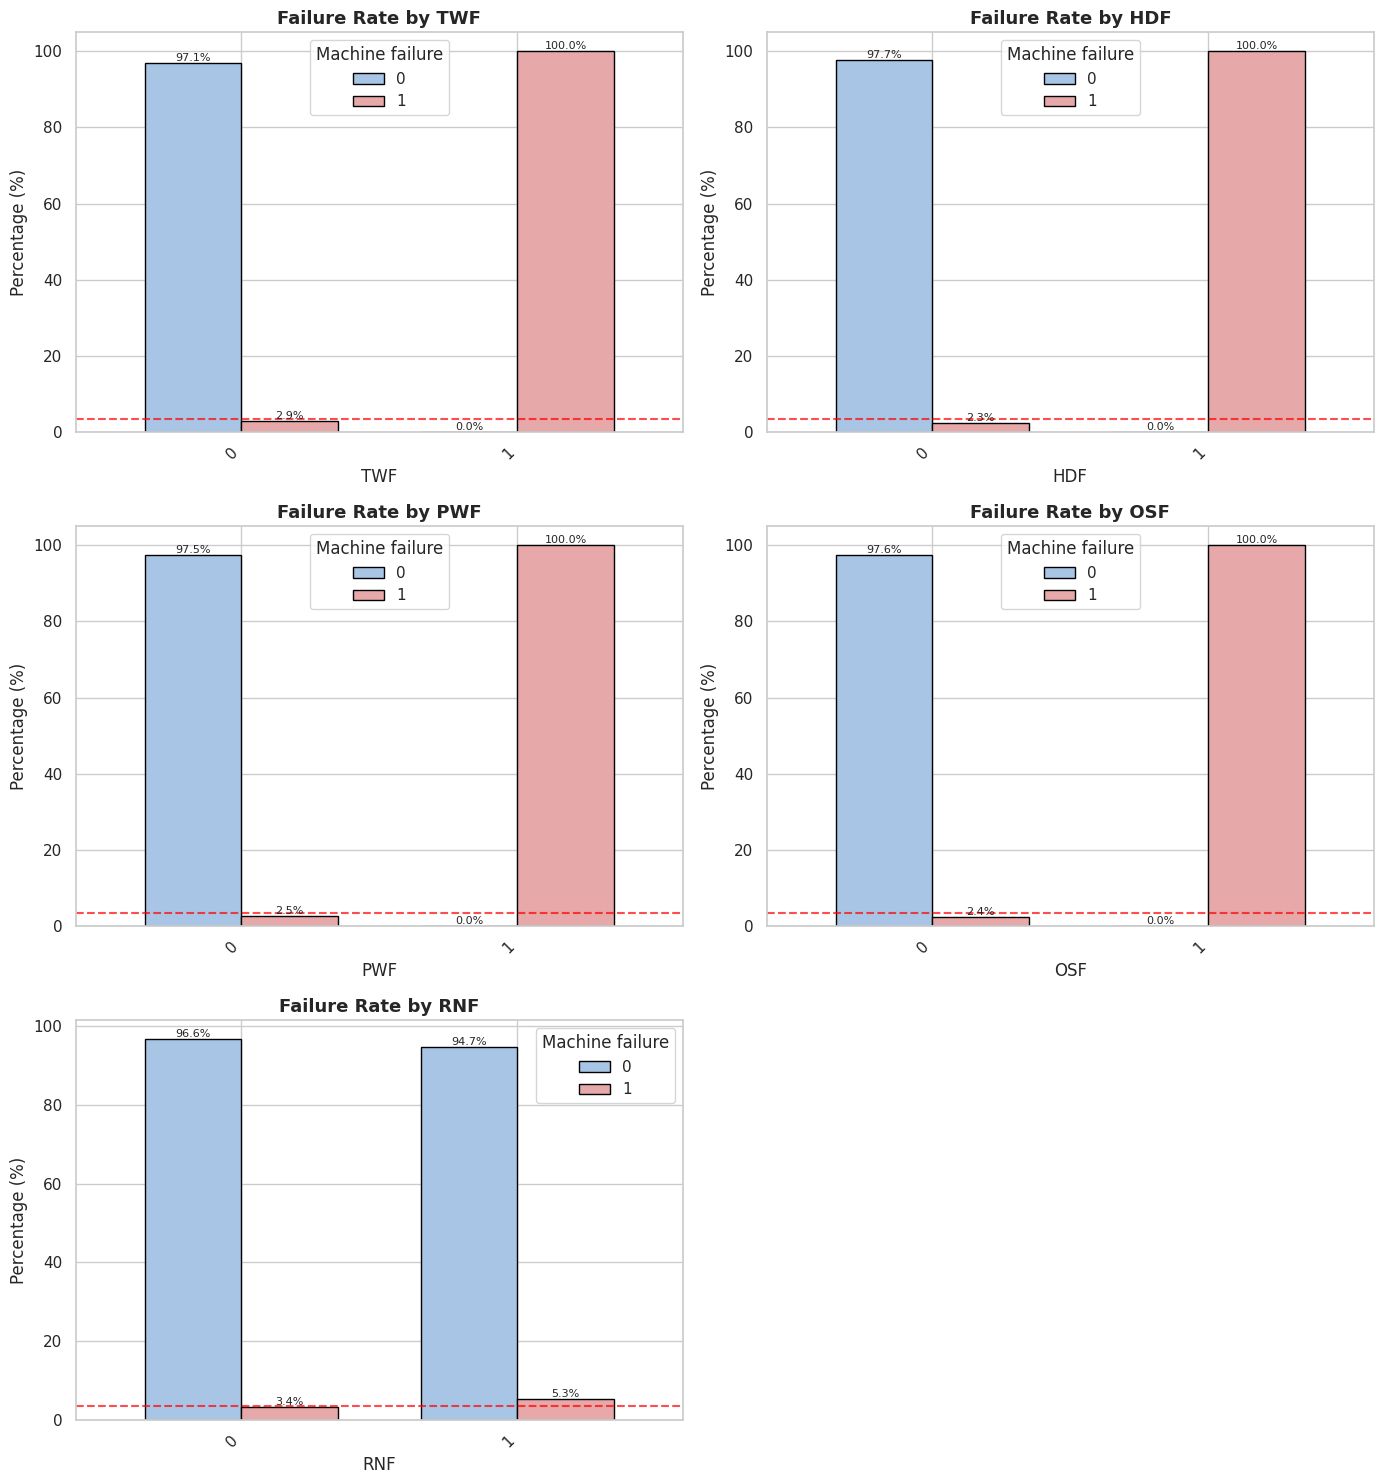

In [ ]:
plot_bivariate_categorical(df, mode_indicators, target_col='Machine failure')

#### Tool Wear Failure [TWF]:
- **Rule**: Triggered when tool wear surpasses a randomly assigned threshold between 200-240 minutes.
- **Interpretation**: Represents late-stage tool degradation, a physics-based end-of-life condition for the cutting tool.
- **Predictive Value**: Despite being rare (~0.46%), TWF captures an essential failure mechanism. It is perfectly aligned with physical expectations and validates tool wear as a key predictive signal.
- **Class Separation**: All TWF events result in machine failure (100%), while non-TWF cycles rarely fail (~2.9%).
- **Modeling Constraint**: TWF must be excluded from training inputs because it directly reveals the target label.
- **Feature Engineering Impact**:
  - Requires engineered features that capture progressive wear rather than the hidden threshold.
  - Motivates creation of Wear-Rate, Wear Bins, and Torque x Wear (mechanical strain) to help the model approximate failure boundaries.
  - Reinforces that Tool Wear is a primary indicator and should be scaled and emphasized during preprocessing.

</br>

---

</br>

#### Heat Dissipation Failure [HDF]
- **Rule**: Triggered when both the temperature gradient (ΔT) falls below 8.6 K and rotational speed drops below 1380 rpm.
- **Interpretation**: Represents a thermodynamic overload condition where insufficient thermal gradient and inadequate airflow cause heat to accumulate faster than it can be dissipated.
- **Predictive Value**: Although rare (1.15%), HDF captures a clear and physically grounded failure mechanism. It confirms that ΔT and RPM must be treated as interacting variables during feature engineering.
- **Class Separation**: All HDF = 1 records correspond to machine failure, while non-HDF cycles fail only ~2.3% of the time.
- **Modeling Constraint**: HDF must be excluded from model inputs to avoid label leakage.
- **Feature Engineering Impact**:
  - Motivates creation of Temperature Gradient (Process Temperature - Air Temperature) as a primary engineered feature that encodes cooling efficiency.
  - Highlights Rotational Speed as a key thermal driver, especially in low-speed regimes.
  - Reinforces the importance of capturing interaction effects between ΔT and RPM, either through deep learning or optional engineered features.

</br>

---

</br>

#### Power Failure [PWF]
- **Rule**: Triggered when the mechanical power (torque x angular velocity) falls outside the safe operating range of 3500-9000 W
- **Interpretation**: Reflects abnormal mechanical load conditions:
  - Under-power ( < 3500 W) = insufficient torque/RPM to sustain the process
  - Over-power ( > 9000 W) = excessive mechanical load, driving unsafe operating states.
- **Predictive Value**: Although rare (~0.95%), PWF captures a critical mechanical failure mechanism. The pattern reinforces the importance of torque and RPM (especially their nonlinear combination) in modeling mechanical stress.
- **Class Separation**: All PWF events correspond to machine failures (100%), whereas non-PWF cycles fail only ~2.5% of the time. This shows a perfect deterministic mapping from PWF to the target label.
- **Modeling Constraint**: PWF must be excluded from model inputs to avoid label leakage.
- **Feature Engineering Impact**:
  - Motivates the explicit creation of Mechanical Power (= torque x 2pi x (RPM/60)) as a continuous input feature.
  - Encourages the model to learn threshold-like behavior in power regimes without exposing the leakage-prone PWF column.
  - Reinforces the need to retain both Torque and RPM (strong contributors to mechanical load), as well as the engineered transformations that combine them.

</br>

---

</br>

#### Overstrain Failure [OSF]
- **Rule**: Triggered when mechanical strain (Torque x Tool Wear) exceeds a type-specific threshold:
  - L-type > 11,000 minNm
  - M-type > 12,000 minNm
  - H-type > 13,000 minNm
- **Interpretation**: OSF represents load-induced mechanical overstress that emerges from the interaction of high torque and high accumulated tool wear. It captures a degradation pathway where the tool becomes structurally incapable of handling operational load.
- **Predictive Value**: OSF encodes the strongest nonlinear relationship in the dataset. It ties together Type, Wear, and Torque into a physically meaningful composite signal. Although rare (~0.98%), it provides powerful insight into a core mechanical failure mechanism.
- **Class Separation**: All OSF events correspond to machine failures (100%). Among cycles without OSF, failures are extremely rare (~2.4%). This shows a perfect deterministic mapping from PWF to the target label.
- **Modeling Constraint**: OSF must be excluded from model inputs to avoid label leakage.
- **Feature Engineering Impact**:
  - Necessitates creation of Mechanical Strain = Torque x Wear as a continuous proxy for the hidden OSF threshold.
  - Motivates deriving Wear-Torque interaction terms, Type-adjusted strain measures, or strain percentile bins to help the model infer OSF likelihood without leaking the rule itself.
  - Reinforces that Torque and Tool Wear are among the most influential raw features and must be scaled carefully during preprocessing.

</br>

---

</br>

#### Random Failure [RNF]
- **Rule**: Triggered purely at random, with a fixed probability of 0.1% per cycle, entirely independent of sensor readings or operating conditions.
- **Interpretation**: RNF is intentionally included in the dataset to prevent models from learning perfectly deterministic rules. It represents irreducible system noise-failures caused by unpredictable shocks, latent defects, or unmodeled phenomena.
- **Predictive Value**: Extremely limited since RNF represents an uncertainty that is part of the real-world failure landscape.
- **Class Separation**: RNF cases show slightly elevated failure rates (≈5.3%), but the variation is stochastic with no meaningful relationship to any input variable.
- **Modeling Constraint**: RNF must be excluded from model inputs because it directly reveals the target label and would cause label leakage.
- **Feature Engineering Impact**:
  - No feature engineering can help predict RNF specifically.
  - Stochastic failures contribute to the dataset's Bayes error as the minimum irreducible error any model will have.
  - Reinforces the need for robust evaluation metrics (PR-AUC, recall) and regularization, since no model should be expected to achieve 100% accuracy.

### 3.5. Operational Features Analysis

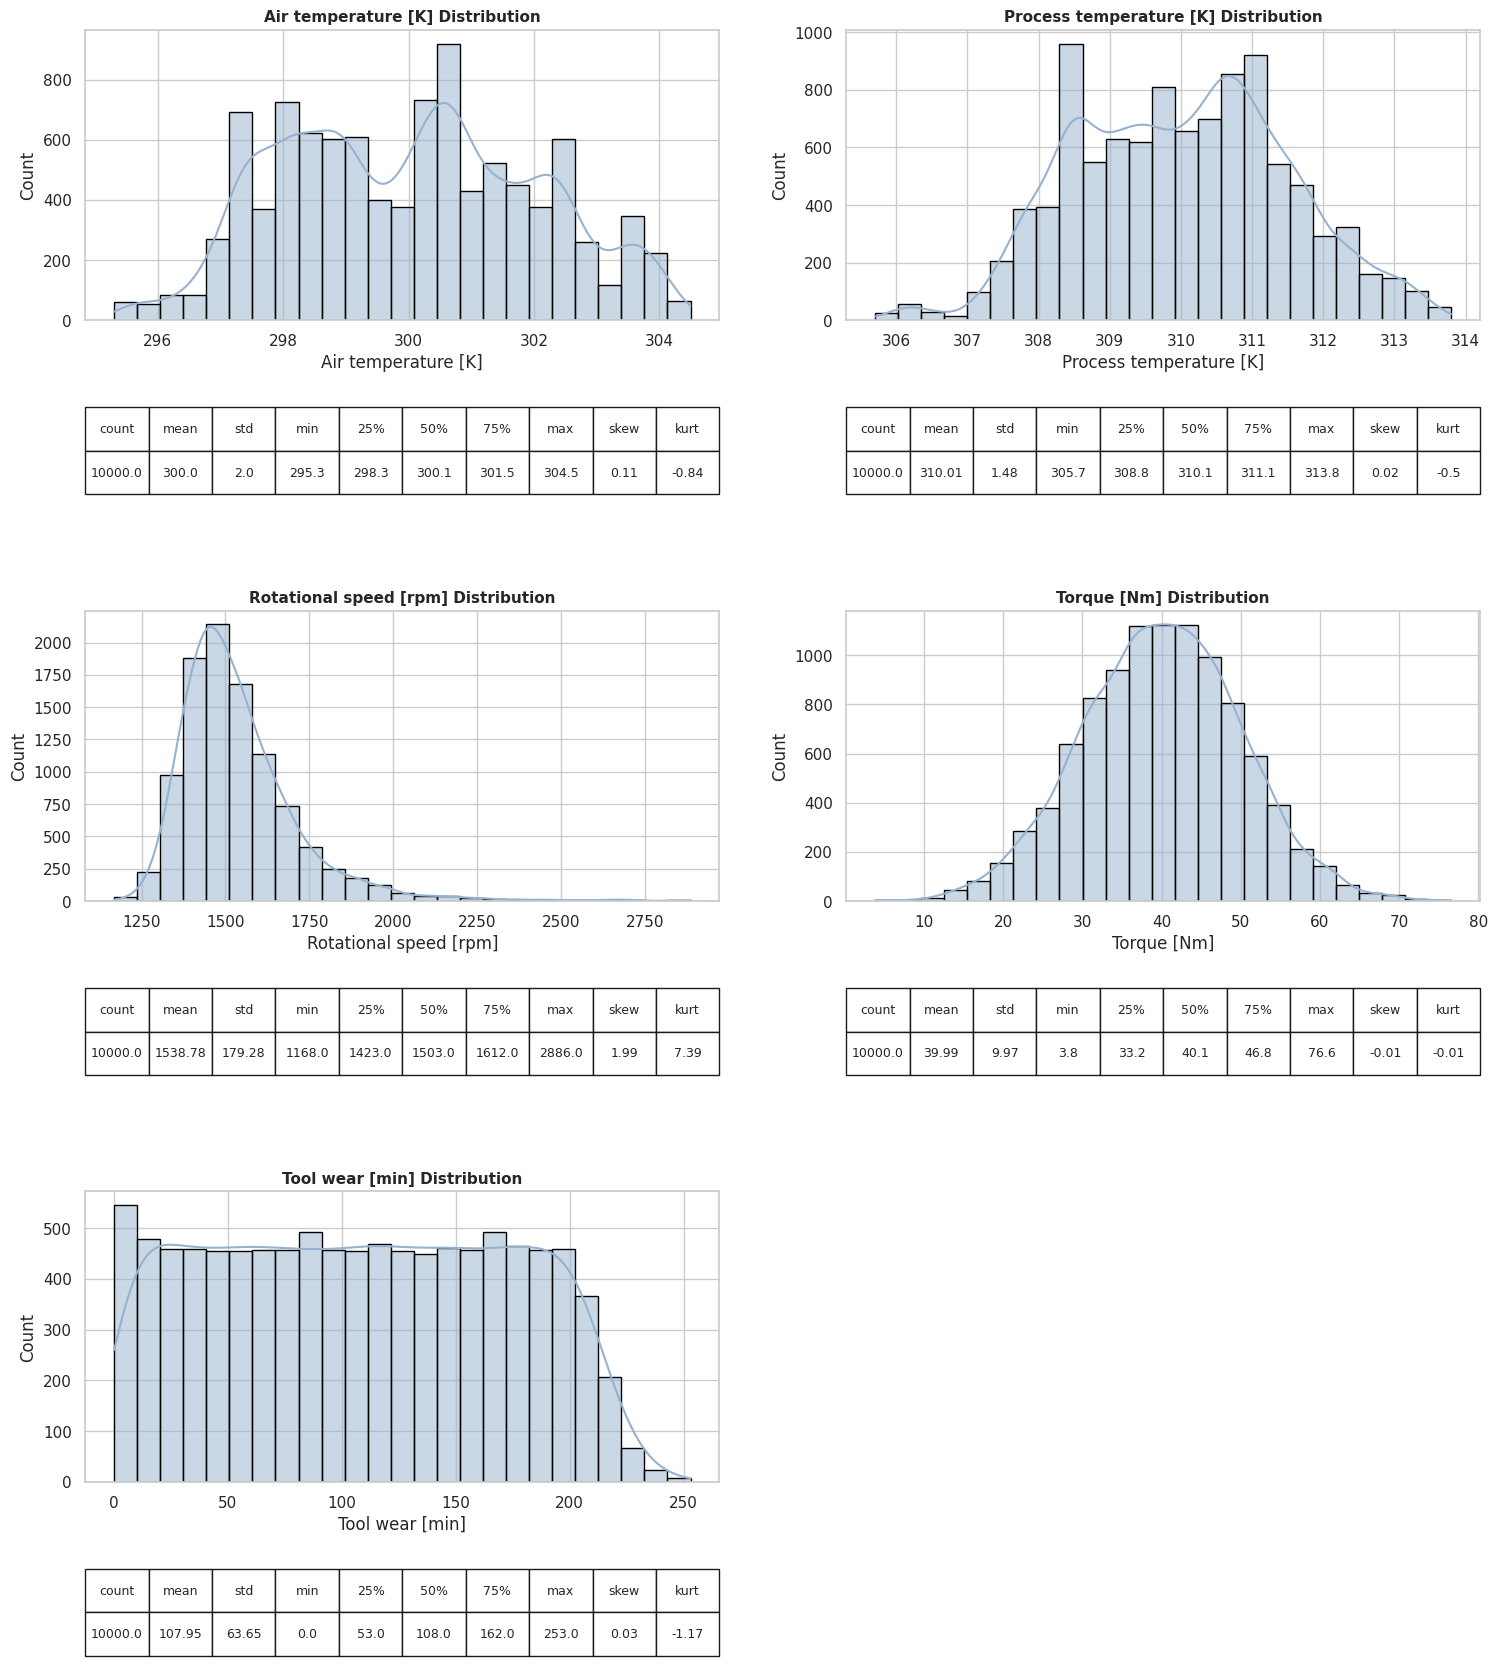

In [ ]:
plot_numeric_distributions(df, numeric_cols)

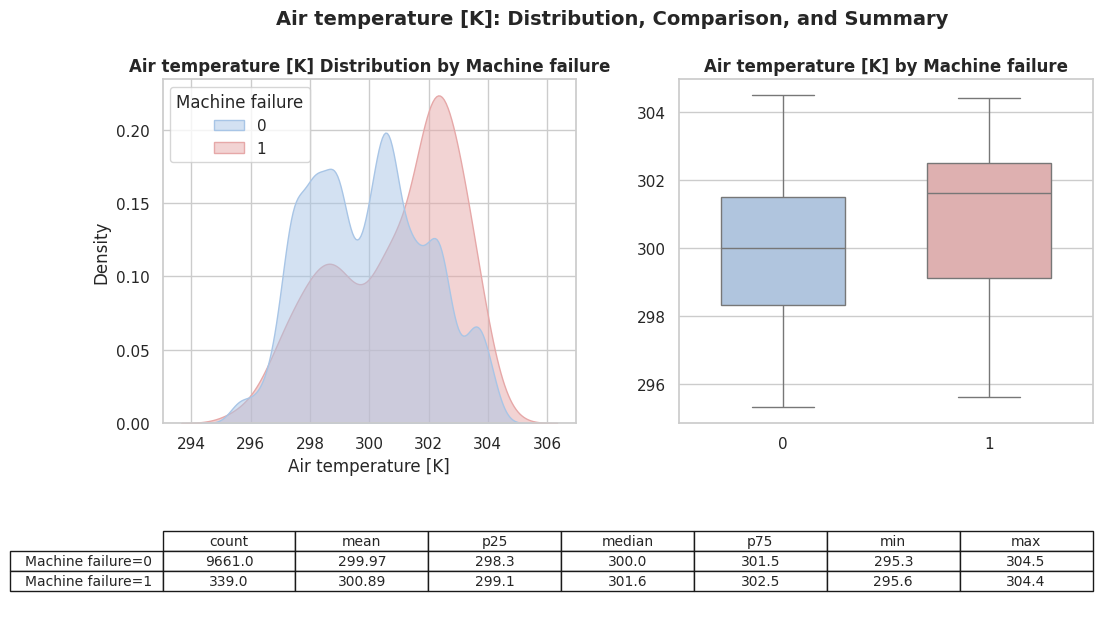

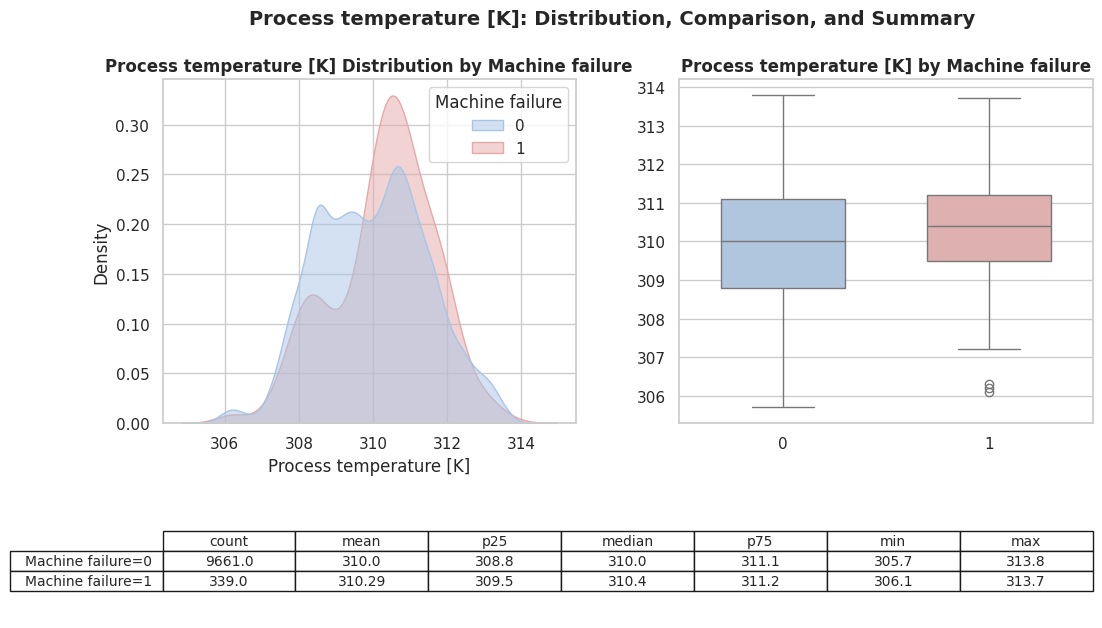

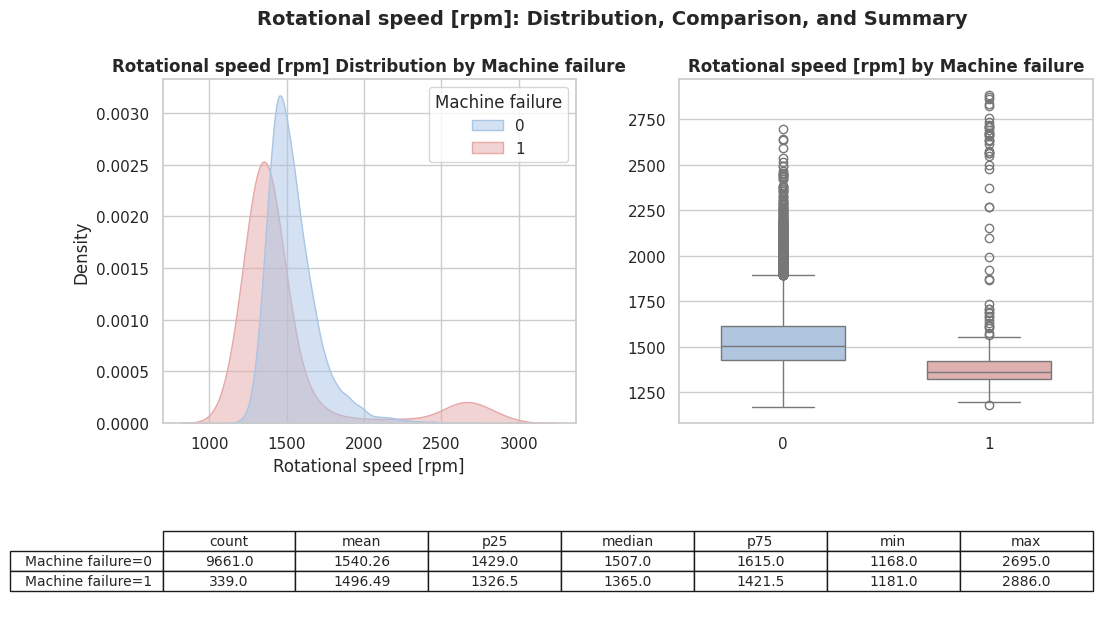

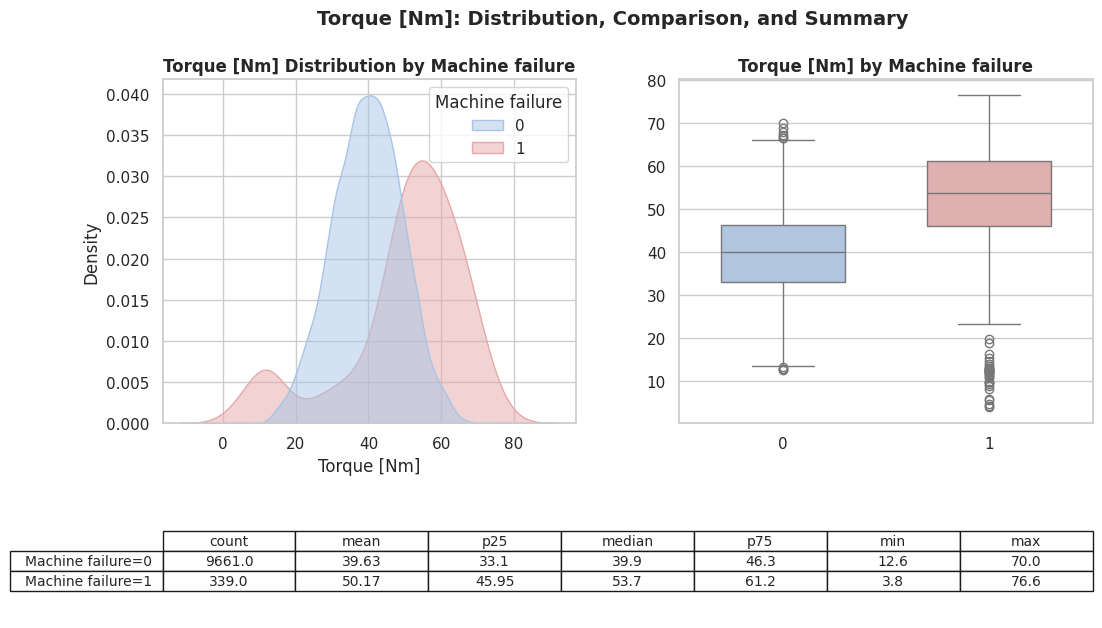

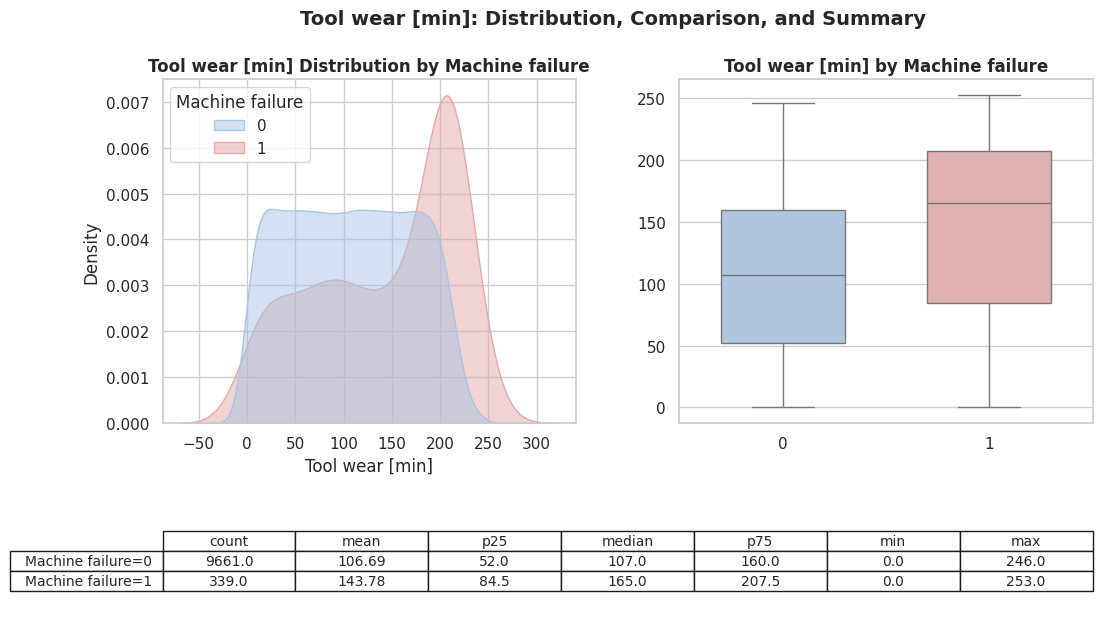

In [ ]:
plot_bivariate_numeric(df, numeric_cols, target='Machine failure')

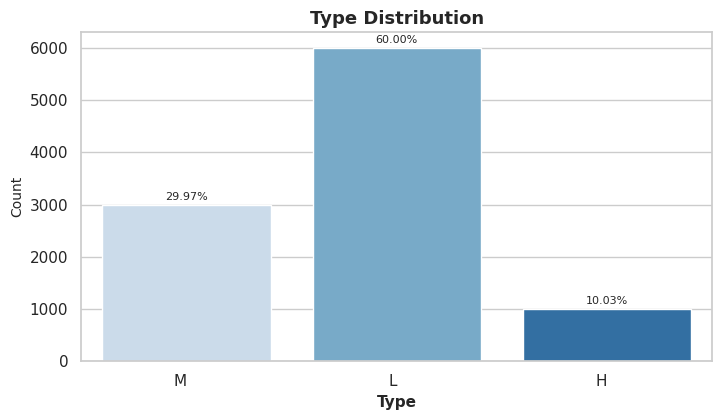

In [ ]:
plot_categorical_distributions(df, categoric_cols)

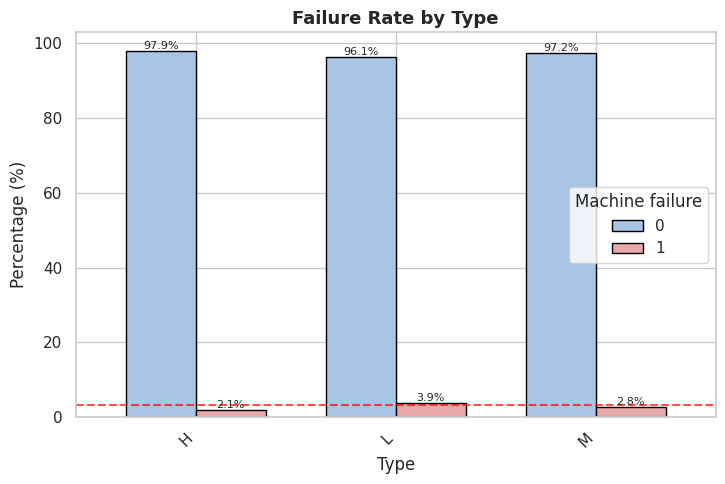

In [ ]:
plot_bivariate_categorical(df, categoric_cols, target_col='Machine failure')

#### Air Temperature [K]
- **Definition**: Continuous variable representing the ambient air temperature surrounding the machine during a production cycle.
- **Distributions**:
  - Approximately normally distributed around 300 K
  - Observed range: ~295-304 K
  - Standard deviation: ~2 K, consistent with the data-generation process
- **Interpretation**: Air temperature defines the external thermal environment and directly influences the system's ability to dissipate heat. Higher air temperatures reduce the temperature gradient between the process and the environment, lowering cooling efficiency and indirectly increasing the risk of thermal overload under low-ventilation conditions.
- **Predictive Value**: Air temperature alone shows only weak separation between failure and non-failure cases, with heavy overlap across classes and a modest upward shift (~1 K) in failure cases. This confirms that air temperature is not an independent predictor of machine failure, but instead contributes predictive value primarily through interactions with other thermal and operational variables.
- **Feature Engineering Notes**:
  - Air Temperature: Retained as a continuous input feature and standardized prior to modeling to represent the ambient thermal baseline influencing cooling behavior.
  - Temperature Gradient [K]: A physics-informed interaction feature capturing cooling efficiency, computed as
    - = Process Temperature - Air Temperature

</br>

---

</br>

#### Process Temperature [K]
- **Definition**: Continuous variable representing the internal operating temperature of the manufacturing process during a production cycle.
- **Distributions**:
  - Approximately normally distributed around 310 K
  - Observed range: ~305.7-313.8 K
  - Standard deviation: ~1.48 K, consistent with the documented simulation process
- **Interpretation**: Process temperature reflects the thermal load generated by the machining operation itself. Higher process temperatures increase thermal stress and reduce the system's margin for effective heat dissipation, especially when ambient air temperature is also elevated.
- **Predictive Value**: Process temperature alone exhibits only weak separation between failure and non-failure cases, with substantial overlap across classes and a small upward shift in failure cases. This confirms that, like air temperature, it should not be treated as an independent predictor of machine failure.
- **Modeling Constraint**:
- **Feature Engineering Notes**:
  - Process Temperature: Retained as a continuous input feature and standardized prior to modeling to represent internal heat generation during operation.
  - Temperature Gradient [K]: Used jointly with air temperature to capture cooling efficiency, computed as
    - = Process Temperature - Air Temperature

</br>

---

</br>

#### Rotational Speed [rpm]
- **Definition**: Continuous variable representing the rotational speed of the machine spindle during a production cycle.
- **Distributions**:
  - Right-skewed distribution with a long upper tail
  - Observed range: ~1168-2886 rpm
  - Mean ≈ 1539 rpm with a standard deviation of ~179 rpm
- **Interpretation**: Rotational speed reflects the operational load regime of the machine. Lower speeds reduce airflow and cooling efficiency, while extreme values contribute to abnormal mechanical power levels. As a result, RPM plays a dual role in both thermal and mechanical failure mechanisms.
- **Predictive Value**: Failure cases are concentrated at lower RPM values, with a clear leftward shift in the distribution and a substantially lower median compared to non-failure cycles. Despite this, RPM alone is still insufficient to deterministically predict failure and must be interpreted in context.
- **Feature Engineering Notes**:
  - Rotational Speed: Retained as a continuous input feature and standardized prior to modeling to represent the machine's operating regime.
  - Mechanical Power: A physics-informed interaction feature capturing instantaneous mechanical load, computed as
    - = Torque x (2π x RPM / 60).

</br>

---

</br>

#### Torque [Nm]
- **Definition**: Continuous variable representing the rotational force applied by the machine during a production cycle.
- **Distributions**:
  - Approximately normally distributed around 40 Nm
  - Observed range: ~3.8-76.6 Nm
  - Standard deviation: ~10 Nm, consistent with the documented simulation process
- **Interpretation**: Torque reflects the instantaneous mechanical load placed on the machine. Higher torque corresponds to increased resistance during operation, directly increasing mechanical stress, energy demand, and strain on the tool, particularly under high-load or late-wear conditions.
- **Predictive Value**: Torque shows very strong separation between failure and non-failure cases. Failure events are characterized by substantially higher torque values, with a pronounced rightward shift in the distribution and consistently elevated percentiles. This indicates that high torque is a dominant contributor to machine failure risk.
- **Feature Engineering Notes**:
  - Torque: Retained as a continuous input feature and standardized prior to modeling to represent instantaneous mechanical load.
  - Mechanical Power: A physics-informed interaction feature capturing instantaneous mechanical load, computed as
    - = Torque x (2π x Rotational Speed / 60)
  - Mechanical Strain: A cumulative interaction feature capturing load-induced material stress on the tool, computed as
    - = Torque x Tool Wear

</br>

---

</br>

#### Tool Wear [min]
- **Definition**: Continuous variable representing the cumulative operational time of the tool, serving as a proxy for progressive tool degradation across production cycles.
- **Distributions**:
  - Broad, approximately uniform distribution across most of the range
  - Observed range: ~0-253 minutes
  - Mean ≈ 108 minutes with a standard deviation of ~63.7 minutes
- **Interpretation**: Tool wear captures the accumulated degradation of the cutting tool over time. As wear increases, the tool becomes less capable of withstanding mechanical load, reducing its tolerance to torque and making it increasingly susceptible to failure under stress.
- **Predictive Value**: Tool wear shows strong and meaningful separation between failure and non-failure cases. Failures are heavily concentrated at higher wear levels, with a pronounced rightward shift in the distribution and substantially higher median and upper quartile values. Low-wear tools rarely fail, confirming wear as a primary driver of failure risk.
- **Feature Engineering Notes**:
  - Tool Wear: Retained as a continuous input feature and standardized prior to modeling to represent accumulated degradation over time.
  - Mechanical Strain: A cumulative interaction feature capturing load-induced material stress on the tool, computed as
    - = Torque x Tool Wear
  - Wear Increment per Cycle: A physics-based mapping that converts product Type into its known wear contribution per production cycle, defined as
    - 2 if Type = L
    - 3 if Type = M
    - 5 if Type = H
  - Effective Wear Load: A continuous interaction feature that scales accumulated tool wear by the Type-specific degradation rate, computed as
    - = Tool Wear x Wear Increment


</br>

---

</br>

#### Product Type [Type]
- **Definition**: Categorical variable representing product quality level
- **Distributions**:
  - L (Low): 60%
  - M (Medium): 30%
  - H (High): 10%
- **Interpretation**: It controls how aggressively the tool degrades, where the higher-quality products place greater mechanical and thermal stress on the tool over time, indirectly increasing failure risk through wear accumulation and strain:
  - L +2 minutes wear per cycle
  - M +3 minutes wear per cycle
  - H +5 minutes wear per cycle
- **Predictive Value**: Failure rates across L, M, and H are nearly identical (~2-4%). No standalone separation is observed between product types and machine failure. This confirms that Type should not be treated as an independent risk factor. However, Type becomes highly informative through interactions, particularly:
  - With Tool Wear (faster accumulation)
  - With Torque (strain tolerance differs by Type)
  - Within Overstrain Failure (OSF) rules, where strain thresholds are Type-specific.
- **Feature Engineering Notes**:
  - Type: Retained as a categorical input (one-hot or embedding) to allow the neural network to learn Type-specific strain tolerance when combined with torque- and wear-based features, without explicitly encoding failure thresholds.
  - Wear Increment per Cycle: A physics-based mapping that converts product Type into its known wear contribution per production cycle, defined as
    - 2 if Type = L
    - 3 if Type = M
    - 5 if Type = H
  - Effective Wear Load: A continuous interaction feature that scales accumulated tool wear by the Type-specific degradation rate, computed as
    - = Tool Wear x Wear Increment

### 3.6. Relationship Analysis

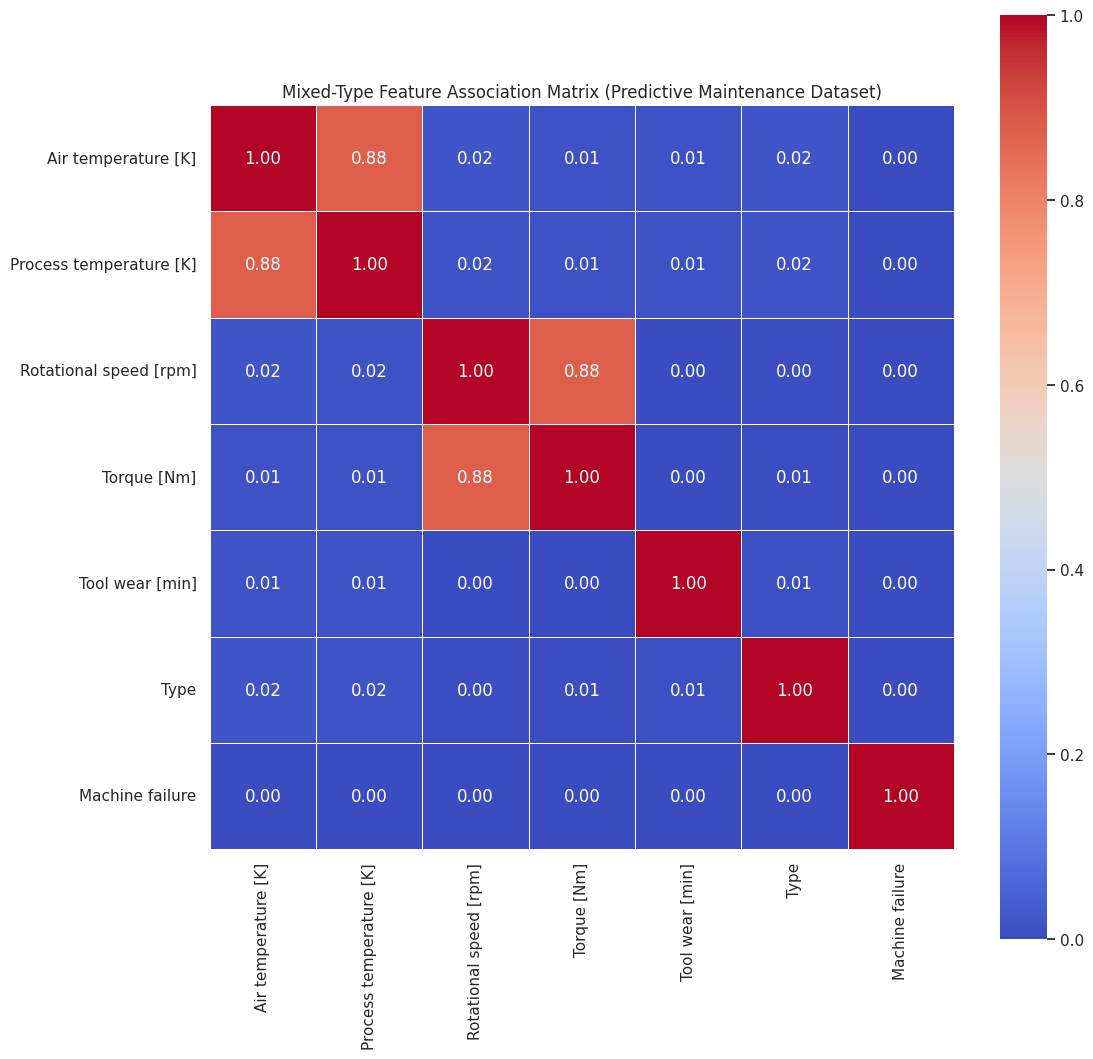

In [ ]:
all_features = numeric_cols + categoric_cols + ['Machine failure']

# Statistical helpers
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))


def correlation_ratio(categories, values):
    df = pd.concat([categories, values], axis=1).dropna()
    categories = df.iloc[:,0]
    values = df.iloc[:,1].astype(float)

    grand_mean = values.mean()
    ss_total = ((values - grand_mean)**2).sum()
    ss_between = sum(len(v)*(v.mean()-grand_mean)**2 for _, v in values.groupby(categories))

    return np.sqrt(ss_between / ss_total)


# mixed-type association matrix
assoc = pd.DataFrame(
    np.zeros((len(all_features), len(all_features))),
    index=all_features,
    columns=all_features
)

for i in all_features:
    for j in all_features:

        if i == j:
            assoc.loc[i, j] = 1.0
            continue

        # numeric–numeric
        if i in numeric_cols and j in numeric_cols:
            r, _ = pearsonr(df[i], df[j])
            assoc.loc[i, j] = abs(r)

        # categorical–categorical (including binary)
        elif i in categoric_cols and j in categoric_cols:
            assoc.loc[i, j] = cramers_v(df[i], df[j])

        # mixed numeric–categorical
        else:
            # i is categorical, j is numeric
            if i in categoric_cols and j in numeric_cols:
                assoc.loc[i, j] = correlation_ratio(df[i], df[j])

            # i is numeric, j is categorical
            elif j in categoric_cols and i in numeric_cols:
                assoc.loc[i, j] = correlation_ratio(df[j], df[i])

# Heatmap
plt.figure(figsize=(12,12))
sns.heatmap(
    assoc, cmap="coolwarm", annot=True, fmt=".2f",
    square=True, linewidths=0.5, cbar=True
)
plt.title("Mixed-Type Feature Association Matrix (Predictive Maintenance Dataset)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

To validate the completeness and appropriateness of the engineered feature set, we perform a multivariate relationship analysis using a mixed-type feature association matrix. This analysis examines pairwise dependencies across numerical and categorical variables, as well as their direct association with the target variable (Machine failure).

</br>

#### Key Relational Observations:
- **Strong intended dependencies are clearly visible**:
  - Air-Process Temperatures show a high association (≈ 0.88), confirming their shared thermal dynamics and justifying the engineered Temperature Gradient feature.
  - Speed-Torque also show strong association (≈ 0.88), reflecting their joint contribution to mechanical load and validating the explicit engineering of Mechanical Power.

- **Low spurious correlations elsewhere**:
  - Tool wear shows negligible correlation with instantaneous operational variables (RPM, torque, temperatures), confirming that it behaves as a cumulative state variable rather than an instantaneous measurement.
  - Similarly, Product Type exhibits minimal direct association with both raw sensor variables and the failure target, indicating that it does not act as an independent risk factor.

- **No strong linear association with the target variable**:
  - All raw features show zero direct association with Machine failure, which is expected given that failures are governed by nonlinear, rule-based interactions rather than linear relationships.
  - This confirms that univariate or linear feature selection methods would be insufficient, and that the engineered interaction features are necessary for effective modeling.

</br>

---

</br>

#### Final List of Features for Engineering:
- **Temperature Gradient [K]** = Process - Air
- **Mechanical Power [W]** = Torque x (2π x RPM / 60)
- **Mechanical Strain** = Torque x Tool Wear
- **Wear Increment per Cycle** (Type -> {2,3,5})
- **Effective Wear Load** = Tool Wear x Wear Increment

</br>

---

</br>

#### Features That Should NOT be Engineered:
- RPM < 1380 indicator
- ΔT < 8.6 indicator
- Wear > 200 indicator
- Type-specific OSF thresholds
- Polynomial features
- Binned versions of continuous variables
- Log / clipping transforms
- Interaction terms beyond the physics ones

This is because explicit threshold indicators would directly encode the failure logic used to generate the dataset, resulting in label leakage and artificially inflated performance. Similarly, generic polynomial features, binned variables, or arbitrary log and clipping transformations would introduce interactions that are not physically motivated and could obscure the underlying failure mechanisms.

## **4. Dataset Preparation**


### 4.1. Feature Engineering

In [ ]:
# Temperature Gradient [K]
df['Temperature Gradient [K]'] = (df['Process temperature [K]'] - df['Air temperature [K]'])

# Mechanical Power [W]
df['Mechanical Power [W]'] = (df['Torque [Nm]'] * (2 * np.pi * df['Rotational speed [rpm]'] / 60))

# Mechanical Strain
df['Mechanical Strain'] = (df['Torque [Nm]'] * df['Tool wear [min]'])

# Wear Increment per Cycle
wear_increment_map = {
    'L': 2,
    'M': 3,
    'H': 5
}

df['Wear Increment per Cycle'] = df['Type'].map(wear_increment_map)

# Effective Wear Load
df['Effective Wear Load'] = (df['Tool wear [min]'] * df['Wear Increment per Cycle'])


### 4.2. Dataset Preparation

In [ ]:
# Remove Failure Mode Indicators (leakage variables)
df.drop(columns=mode_indicators, inplace=True)


In [ ]:
# Sanity Check
print("Shape:", df.shape)
print("")
df.info()
print("")
df.describe().T

Shape: (10000, 12)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      10000 non-null  object 
 1   Air temperature [K]       10000 non-null  float64
 2   Process temperature [K]   10000 non-null  float64
 3   Rotational speed [rpm]    10000 non-null  int64  
 4   Torque [Nm]               10000 non-null  float64
 5   Tool wear [min]           10000 non-null  int64  
 6   Machine failure           10000 non-null  int64  
 7   Temperature Gradient [K]  10000 non-null  float64
 8   Mechanical Power [W]      10000 non-null  float64
 9   Mechanical Strain         10000 non-null  float64
 10  Wear Increment per Cycle  10000 non-null  int64  
 11  Effective Wear Load       10000 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 1015.6+ KB



,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.004930,2.000259,295.30000,298.300000,300.100000,301.500000,304.500000
Process temperature [K],10000.0,310.005560,1.483734,305.70000,308.800000,310.100000,311.100000,313.800000
Rotational speed [rpm],10000.0,1538.776100,179.284096,1168.00000,1423.000000,1503.000000,1612.000000,2886.000000
Torque [Nm],10000.0,39.986910,9.968934,3.80000,33.200000,40.100000,46.800000,76.600000
Tool wear [min],10000.0,107.951000,63.654147,0.00000,53.000000,108.000000,162.000000,253.000000
Machine failure,10000.0,0.033900,0.180981,0.00000,0.000000,0.000000,0.000000,1.000000
Temperature Gradient [K],10000.0,10.000630,1.001094,7.60000,9.300000,9.800000,11.000000,12.100000
Mechanical Power [W],10000.0,6279.744953,1067.418295,1148.44061,5561.184484,6271.027344,7003.002724,10469.923005
Mechanical Strain,10000.0,4314.664550,2826.567692,0.00000,1963.650000,4012.950000,6279.000000,16497.000000
Wear Increment per Cycle,10000.0,2.600600,0.917477,2.00000,2.000000,2.000000,3.000000,5.000000


### 4.3. Train - Test Split

In [ ]:
# Separate features and target
X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

# Stratified Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Verify class balance is preserved
print("Failure rate (%):")
print(f"Train: {y_train.mean() * 100:.2f}%")
print(f"Test:  {y_test.mean() * 100:.2f}%")

Failure rate (%):
Train: 3.39%
Test:  3.40%


#### Handling Class Imbalance

Machine failures represent approximately 3.4% of all observations, creating a strong class imbalance. In an operational context, failing to detect an imminent machine failure (false negative) is substantially more costly than raising a false alarm (false positive).

To address this:
- No resampling techniques (e.g., SMOTE) are applied, as synthetic samples would violate the physics-based structure of the data.
- Class-weighted loss functions are used during training, increasing the penalty associated with misclassifying failure cases.
- Model evaluation prioritizes recall, F1-score, and Precision–Recall AUC, rather than raw accuracy.

This strategy ensures that the model focuses on detecting rare but critical failure events without distorting the underlying data distribution.

### 4.4. Preprocessing (Train-Fit, Train/Test Transform)

In [ ]:
# Define feature groups
categorical_features = ['Type']

numerical_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Temperature Gradient [K]',
    'Mechanical Power [W]',
    'Mechanical Strain',
    'Wear Increment per Cycle',
    'Effective Wear Load'
]


# Build preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit on training data only, then transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Sanity check
print("Processed training shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)

Processed training shape: (8000, 12)
Processed test shape: (2000, 12)


## **5. Model Development and Training**

### 5.1. Model Development, Training, and Evaluation Strategy

The modelling phase aims to learn a reliable mapping from per-cycle operating conditions to machine failure risk. To enable systematic comparison, all experiments are conducted within a consistent global framework that fixes the model family, optimisation strategy, training procedure, and evaluation criteria. Within this framework, a sequence of controlled experiments is used to assess the impact of architectural capacity and regularisation on failure detection performance.

</br>

##### Global Model Framework

**Task:** Binary classification (machine failure vs. non-failure)

**Model Family:** Fully connected deep neural networks (Multilayer Perceptrons, MLPs)

**Data Splits:** Stratified train/validation/test split (80/20 for train-test; validation drawn from training data)

**Class Imbalance Handling:** Class-weighted loss functions (no resampling or synthetic data generation)

**Evaluation Metrics:** Recall and PR-AUC prioritised for model comparison; accuracy not used due to class imbalance

**Input Representation:** Fixed-length numerical feature vectors after preprocessing

**Hidden Layer Activation:** ReLU

**Output Activation:** Sigmoid (producing a continuous per-cycle failure risk score)

**Loss Function:** Binary cross-entropy with class weighting to address severe class imbalance

**Optimizer:** Adam

**Training Strategy:** Mini-batch gradient descent with early stopping based on validation loss

</br>

##### Model Architectures and Experiments

Starting from a baseline MLP, a small number of targeted architectural and regularisation modifications are introduced to assess their impact on failure detection performance. All models are trained and evaluated using identical data splits, preprocessing pipelines, optimisation settings, and evaluation metrics to ensure fair comparison. Model selection is based exclusively on validation performance, with the test set reserved for a single final evaluation.


### 5.2. Baseline Model

> Can a simple neural network learn the failure patterns at all?

The baseline model serves as a reference point for evaluating the impact of increased model capacity and regularization strategies introduced in later sections. Its purpose is not to maximize predictive performance, but to verify that the engineered features contain sufficient signal for failure detection and to establish a reasonable lower bound for deep learning performance.

#### 5.2.1. Architecture Definition

##### Design Rationale

The baseline architecture is a moderately sized Multilayer Perceptron with two hidden layers and no explicit regularization. This design balances simplicity and expressive power while minimizing overfitting risk at this early stage. A single hidden layer may be insufficient to capture these higher-order relationships, whereas deeper architectures are deferred to later experiments.

</br>

##### Architecture summary
- Input: preprocessed feature vector
- Hidden Layer 1: 32 neurons, ReLU
- Hidden Layer 2: 16 neurons, ReLU
- Output Layer: 1 neuron, Sigmoid

No dropout or weight decay is applied in the baseline model to ensure that performance reflects representational capacity rather than regularization effects.

#### 5.2.2. Training Procedure and Baseline Results

In [ ]:
# Create a fixed validation set from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training samples: {X_train_final.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 6400
Validation samples: 1600


In [ ]:
# Input dimension
input_dim = X_train_final.shape[1]

# Baseline MLP model
baseline_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
baseline_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.AUC(name='roc_auc'),
        keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_final
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

class_weight_dict

{0: np.float64(0.5175481158013909), 1: np.float64(14.746543778801843)}

In [ ]:
# Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Train the Model
history_baseline = baseline_model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.6388 - pr_auc: 0.1341 - precision: 0.0387 - recall: 0.8789 - roc_auc: 0.6634 - val_loss: 0.5914 - val_pr_auc: 0.3257 - val_precision: 0.0911 - val_recall: 0.7593 - val_roc_auc: 0.8409
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4675 - pr_auc: 0.3320 - precision: 0.0981 - recall: 0.8658 - roc_auc: 0.8768 - val_loss: 0.4834 - val_pr_auc: 0.4181 - val_precision: 0.1233 - val_recall: 0.8519 - val_roc_auc: 0.8925
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3996 - pr_auc: 0.3954 - precision: 0.1175 - recall: 0.8192 - roc_auc: 0.9029 - val_loss: 0.4213 - val_pr_auc: 0.4838 - val_precision: 0.1415 - val_recall: 0.8519 - val_roc_auc: 0.9140
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3600 - pr_auc: 0.4395 - precision: 0.1275 - recall: 0.8114 - roc_auc: 0.9178 - val_loss: 0.3791 - val_pr_auc: 0.5267 - val_precision: 0.1586 - val_recall: 0.8519 - val_roc_auc: 0.9252
Epoch 5/100

Training dynamics are examined by analyzing loss and recall curves for both the training and validation sets.

The loss curves show smooth and closely aligned convergence, indicating stable optimization behavior and no evidence of overfitting. Validation loss closely tracks training loss throughout training, suggesting that the baseline architecture is appropriately sized for the dataset and that the engineered features provide a strong inductive bias.

The recall curves show that the model rapidly learns to detect failure events, achieving high recall early in training. While training recall continues to increase slightly with additional epochs, validation recall stabilizes and exhibits minor fluctuations. This behavior is expected in highly imbalanced classification problems, where recall is sensitive to small changes in decision boundaries.

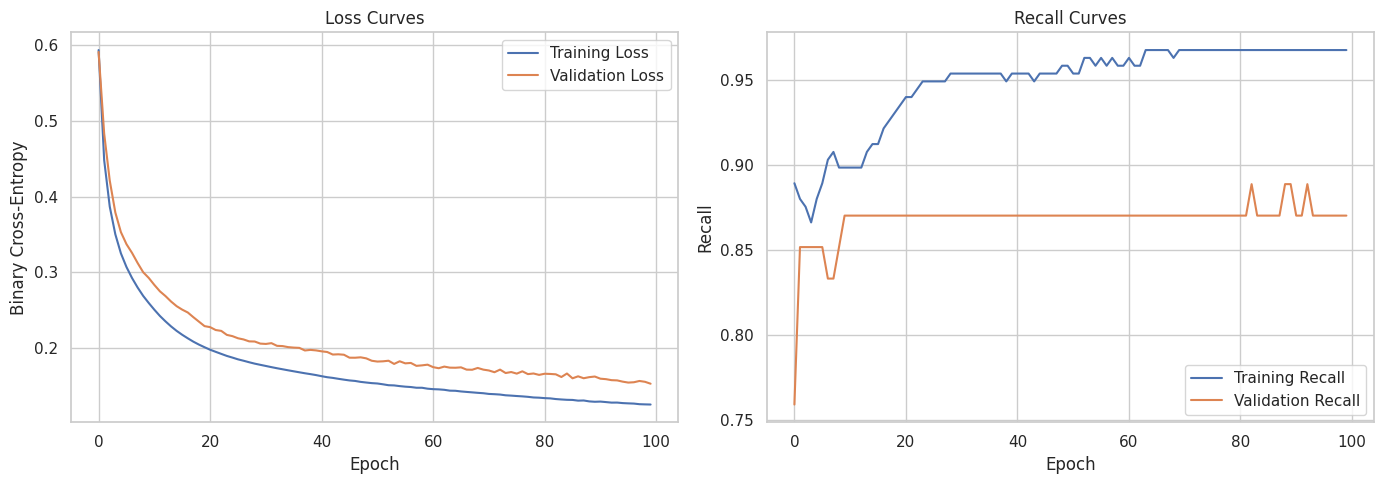

In [ ]:
# Plot Training Dynamics
history_df = pd.DataFrame(history_baseline.history)

plt.figure(figsize=(14,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy')
plt.title('Loss Curves')
plt.legend()

# Recall curve
plt.subplot(1,2,2)
plt.plot(history_df['recall'], label='Training Recall')
plt.plot(history_df['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curves')
plt.legend()

plt.tight_layout()
plt.show()

To summarize baseline performance, validation metrics are extracted from the epoch with the lowest validation loss. This ensures that reported metrics correspond to the model state with the best observed generalization performance.

The baseline model achieves:
- High recall on failure cases, indicating strong sensitivity to rare but critical failure events
- Reasonable precision, reflecting an acceptable false-alarm rate given the operational emphasis on recall
- Strong ROC-AUC and PR-AUC values, confirming that the model effectively ranks failure risk despite class imbalance

Overall, these results demonstrate that even a relatively simple deep neural network can successfully learn the dominant failure mechanisms present in the data. The baseline model therefore provides a strong foundation for subsequent experiments involving increased model capacity, regularization, and threshold optimization.

In [ ]:
history_df = pd.DataFrame(history_baseline.history)

# Best epoch based on validation loss
best_epoch = history_df['val_loss'].idxmin()

baseline_val_results = {
    'val_loss': history_df.loc[best_epoch, 'val_loss'],
    'val_recall': history_df.loc[best_epoch, 'val_recall'],
    'val_precision': history_df.loc[best_epoch, 'val_precision'],
    'val_roc_auc': history_df.loc[best_epoch, 'val_roc_auc'],
    'val_pr_auc': history_df.loc[best_epoch, 'val_pr_auc']
}

baseline_val_results

{'val_loss': np.float64(0.15259328484535217),
 'val_recall': np.float64(0.8703703880310059),
 'val_precision': np.float64(0.33571428060531616),
 'val_roc_auc': np.float64(0.9646878838539124),
 'val_pr_auc': np.float64(0.7233753204345703)}

### 5.3. Capacity Expansion Experiment

> Does increasing model capacity improve failure detection performance?

To assess whether the baseline architecture is sufficiently expressive, a controlled capacity expansion experiment is conducted. By isolating model capacity as the only experimental variable, this section examines whether the baseline model was underfitting the underlying failure mechanisms.

#### 5.3.1. Architecture Definition



##### Design Rationale

The expanded architecture increases the number of neurons and introduces an additional hidden layer, allowing the network to represent more complex and higher-order feature interactions. This is particularly relevant for failure prediction tasks, where nonlinear combinations of operational variables may contribute to rare failure events.

To isolate the effect of model capacity, no explicit regularization is introduced. This ensures that any observed differences in performance can be attributed directly to increased representational capacity rather than to changes in regularization or optimization behavior.

</br>

##### Architecture Summary
- Input: preprocessed feature vector
- Hidden Layer 1: **64 neurons**, ReLU
- Hidden Layer 2: **32 neurons**, ReLU
- **Hidden Layer 3**: **16 neurons**, ReLU
- Output Layer: 1 neuron, Sigmoid

#### 5.4.2. Training Procedure and Higher-Capacity Results


The capacity-expanded model is trained using the same fixed training, validation, and test splits as the baseline model. The preprocessing pipeline, optimization settings, class-weighted loss, early stopping criteria, and evaluation metrics are all unchanged. This controlled setup ensures that architectural capacity is the only factor influencing performance differences.

In [ ]:
# Capacity-expanded MLP model
capacity_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model (identical to baseline)
capacity_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.AUC(name='roc_auc'),
        keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)

capacity_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history_capacity = capacity_model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.5933 - pr_auc: 0.2417 - precision: 0.0533 - recall: 0.8153 - roc_auc: 0.7578 - val_loss: 0.4947 - val_pr_auc: 0.4338 - val_precision: 0.1182 - val_recall: 0.8889 - val_roc_auc: 0.9003
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3918 - pr_auc: 0.3911 - precision: 0.1241 - recall: 0.8839 - roc_auc: 0.9091 - val_loss: 0.3518 - val_pr_auc: 0.5491 - val_precision: 0.1685 - val_recall: 0.8333 - val_roc_auc: 0.9288
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3090 - pr_auc: 0.4738 - precision: 0.1610 - recall: 0.8825 - roc_auc: 0.9416 - val_loss: 0.2925 - val_pr_auc: 0.6064 - val_precision: 0.2054 - val_recall: 0.8519 - val_roc_auc: 0.9383
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2690 - pr_auc: 0.5555 - precision: 0.1820 - recall: 0.8592 - roc_auc: 0.9556 - val_loss: 0.2745 - val_pr_auc: 0.6252 - val_precision: 0.2176 - val_recall: 0.8704 - val_roc_auc: 0.9447
Epoch 5/100

Training and validation loss curves indicate stable optimization behavior, with training loss decreasing steadily over epochs. However, compared to the baseline model, the validation loss shows slightly increased separation from training loss at later epochs, suggesting a mild increase in overfitting risk due to the larger model capacity.

Recall curves reveal that while the training recall continues to improve with increased capacity, validation recall does not exhibit corresponding gains. In some cases, validation recall plateaus or decreases slightly relative to the baseline model, indicating that the additional capacity does not translate into improved failure detection on unseen data.

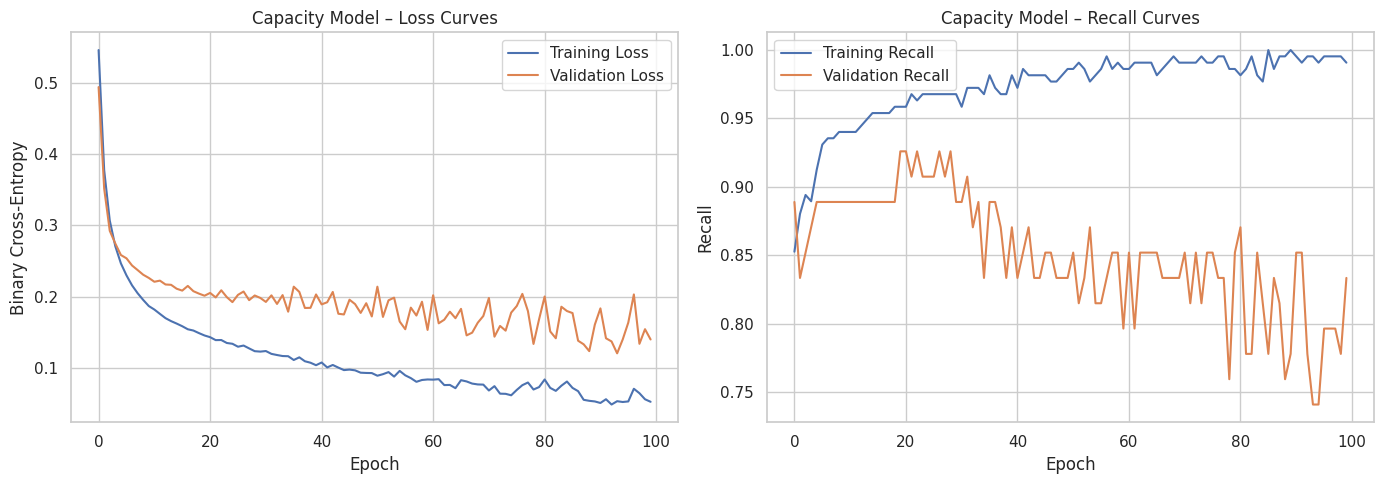

In [ ]:
# Plot training dynamics

history_capacity_df = pd.DataFrame(history_capacity.history)

plt.figure(figsize=(14,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history_capacity_df['loss'], label='Training Loss')
plt.plot(history_capacity_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy')
plt.title('Capacity Model – Loss Curves')
plt.legend()

# Recall curve
plt.subplot(1,2,2)
plt.plot(history_capacity_df['recall'], label='Training Recall')
plt.plot(history_capacity_df['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Capacity Model – Recall Curves')
plt.legend()

plt.tight_layout()
plt.show()

Validation metrics are extracted from the epoch with the lowest validation loss, using the same selection criterion applied to the baseline model. Compared to the baseline architecture, the higher-capacity model exhibits:
- Slightly higher precision, indicating fewer false alarms
- Lower or unchanged recall, indicating more missed failure events
- Comparable ROC-AUC and PR-AUC, suggesting no meaningful improvement in ranking performance

Because failure detection prioritizes sensitivity to rare but critical failure events, the observed reduction in recall outweighs the modest gains in precision. This indicates that the additional layers and neurons do not uncover new failure patterns, but instead lead the model to adopt a more conservative decision boundary.

In [ ]:
# Extract best-epoch validation results (same logic as baseline)

best_epoch_capacity = history_capacity_df['val_loss'].idxmin()

capacity_val_results = {
    'val_loss': history_capacity_df.loc[best_epoch_capacity, 'val_loss'],
    'val_recall': history_capacity_df.loc[best_epoch_capacity, 'val_recall'],
    'val_precision': history_capacity_df.loc[best_epoch_capacity, 'val_precision'],
    'val_roc_auc': history_capacity_df.loc[best_epoch_capacity, 'val_roc_auc'],
    'val_pr_auc': history_capacity_df.loc[best_epoch_capacity, 'val_pr_auc']
}

capacity_val_results

{'val_loss': np.float64(0.12007025629281998),
 'val_recall': np.float64(0.7407407164573669),
 'val_precision': np.float64(0.4651162922382355),
 'val_roc_auc': np.float64(0.9467803239822388),
 'val_pr_auc': np.float64(0.7368073463439941)}

In [ ]:
# Compare to Baseline

baseline_val_results

{'val_loss': np.float64(0.15259328484535217),
 'val_recall': np.float64(0.8703703880310059),
 'val_precision': np.float64(0.33571428060531616),
 'val_roc_auc': np.float64(0.9646878838539124),
 'val_pr_auc': np.float64(0.7233753204345703)}

**Verdict:**

Although the higher-capacity model achieves higher precision, this improvement comes without any gain in recall and is accompanied by a decline in PR-AUC. Because predictive maintenance prioritizes identifying as many true failures as possible and relies on reliable failure ranking for threshold optimization, the baseline model remains the preferable choice.

### 5.4. Regularization Experiments (dropout vs L2 vs best combo)

> Can controlled regularization improve generalization and rare-failure detection without increasing model capacity?

The regularization experiments investigate whether constraining how the baseline model learns can improve generalization and failure ranking performance under strong class imbalance. Unlike the capacity expansion experiment, the goal here is not to increase representational power, but to regulate how the existing capacity is used.

#### 5.4.1. Architecture Definition

##### Design Rationale

We will conduct 3 experiments here:

**5.4.2. Dropout Regularization**: By randomly deactivating a fraction of hidden units during training, dropout forces the model to learn more distributed and robust representations. This can be beneficial in imbalanced datasets by reducing overconfident decision boundaries. Dropout rates were evaluated in the range:
- 0.1
- 0.2
- 0.3

**5.4.3. L2 Weight Decay Regularization**: L2 regularization (weight decay) penalizes large weights during optimization, encouraging smoother decision boundaries. While this can reduce variance and improve stability, it may also weaken the nonlinear interactions required to model threshold-based mechanical failures. The following L2 values were evaluated:
- 1e-5
- 1e-4
- 1e-3

**5.4.4. Combined Regularization (Dropout + L2)**: A final experiment combined the best-performing individual regularization settings.

</br>

##### Architecture Summary
- Input: preprocessed feature vector
- Hidden Layer 1: 32 neurons, ReLU **(L2)**
- **Dropout Layer**: applied after Hidden Layer 1
- Hidden Layer 2: 16 neurons, ReLU **(L2)**
- **Dropout Layer**: applied after Hidden Layer 2
- Output Layer: 1 neuron, Sigmoid

</br>

The regularized model is trained using the same data split, preprocessing pipeline, optimization settings, class-weighting strategy, and evaluation metrics as both the baseline and capacity-expanded models. This ensures that regularization is the only factor under evaluation.

In [ ]:
# Identical to how you trained the baseline and capacity models, except verbose=0 suppresses output so sweeps don’t flood the notebook
def train_and_score(model, model_name):
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=0,
        shuffle=True
    )
    df = pd.DataFrame(history.history)
    best = df['val_loss'].idxmin()
    return {
    "model": model_name,
    "best_epoch": int(best),
    "val_loss": float(df.loc[best, "val_loss"]),
    "val_recall": float(df.loc[best, "val_recall"]),
    "val_precision": float(df.loc[best, "val_precision"]),
    "val_roc_auc": float(df.loc[best, "val_roc_auc"]),
    "val_pr_auc": float(df.loc[best, "val_pr_auc"]),
}


#### 5.4.2. Dropout Regularization Experiment

In [ ]:
# Dropout Sweep
dropout_rates = [0.1, 0.2, 0.3]
dropout_results = []

for dr in dropout_rates:
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dr),
        layers.Dense(16, activation='relu'),
        layers.Dropout(dr),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.AUC(curve='PR', name='pr_auc')
        ]
    )
    dropout_results.append(train_and_score(model, f"Dropout={dr}"))

dropout_df = pd.DataFrame(dropout_results).sort_values("val_pr_auc", ascending=False)
dropout_df

,model,best_epoch,val_loss,val_recall,val_precision,val_roc_auc,val_pr_auc
0,Dropout=0.1,51,0.193073,0.870370,0.281437,0.965838,0.744745
2,Dropout=0.3,53,0.217501,0.888889,0.275862,0.961220,0.717908
1,Dropout=0.2,47,0.210935,0.833333,0.255682,0.956022,0.702439


Mild dropout (0.1) provides the best balance between improving generalization and preserving the model's ability to learn meaningful failure patterns. While higher dropout rates increase recall, they do so by predicting failures more often overall, which leads to more false alarms and a clear drop in PR-AUC. This indicates that stronger dropout does not improve the model's ability to distinguish real failures, but instead makes it overly cautious. In contrast, dropout = 0.1 improves robustness without disrupting the learning of important interaction effects, making it the most effective regularization setting for this task.

#### 5.4.3. L2 Weight Decay Regularization

In [ ]:
# L2 Sweep
l2_values = [1e-5, 1e-4, 1e-3]
l2_results = []

for l2v in l2_values:
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2v)),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2v)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.AUC(curve='PR', name='pr_auc')
        ]
    )
    l2_results.append(train_and_score(model, f"L2={l2v:g}"))

l2_df = pd.DataFrame(l2_results).sort_values("val_pr_auc", ascending=False)
l2_df

,model,best_epoch,val_loss,val_recall,val_precision,val_roc_auc,val_pr_auc
2,L2=0.001,57,0.229529,0.870370,0.267045,0.954434,0.704798
0,L2=1e-05,96,0.160479,0.851852,0.326241,0.962759,0.688028
1,L2=0.0001,93,0.185670,0.851852,0.304636,0.955944,0.659744


L2 regularization provides limited benefits in this setting. Very small L2 values behave similarly to the unregularized baseline, offering slightly higher precision but weaker failure detection. Stronger L2 penalties increase recall but noticeably reduce PR-AUC, indicating that the model becomes overly constrained and less effective at ranking true failure cases. A moderate L2 value (1e-4) offers the best balance among the tested values, but it still underperforms compared to mild dropout. This suggests that penalizing weight magnitude interferes with learning the sharp interaction effects that drive machine failures.

#### 5.4.4. Combined Regularization (Best Dropout + L2)

In [ ]:
# Best Combo Sweep
best_dr = dropout_df.iloc[0]["model"].split("=")[1]
best_dr = float(best_dr)

best_l2 = l2_df.iloc[0]["model"].split("=")[1]
best_l2 = float(best_l2)

combo_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(best_l2)),
    layers.Dropout(best_dr),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(best_l2)),
    layers.Dropout(best_dr),
    layers.Dense(1, activation='sigmoid')
])

combo_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.AUC(name='roc_auc'),
        keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)

combo_result = train_and_score(combo_model, f"Combo: Dropout={best_dr}, L2={best_l2:g}")
combo_result

{'model': 'Combo: Dropout=0.1, L2=0.001',
 'best_epoch': 80,
 'val_loss': 0.21780532598495483,
 'val_recall': 0.8888888955116272,
 'val_precision': 0.29447853565216064,
 'val_roc_auc': 0.9606271982192993,
 'val_pr_auc': 0.7260745167732239}

Using dropout and L2 together makes the model too restrictive. While recall improves slightly, the model becomes less accurate overall and worse at ranking real failure cases. This suggests that combining both forms of regularization limits the model’s ability to learn important failure patterns, so the combined approach is not beneficial.

## **6. Decision Threshold Optimization and Final Evaluation**

### 6.1. Selected Model for Threshold Optimization

Based on the model comparison experiments in Section 5, the following model is selected for deployment-level optimization:
- Architecture: Baseline MLP
- Regularization: Dropout = 0.1
- Training protocol: Identical to previous experiments
- Selection criteria: Best validation PR-AUC with preserved recall

This model demonstrated the strongest ability to rank rare failure cases while maintaining high sensitivity, making it the most suitable candidate for threshold optimization.

In [ ]:
# Train the final selected model
final_dropout = 0.1

final_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(final_dropout),
    layers.Dense(16, activation='relu'),
    layers.Dropout(final_dropout),
    layers.Dense(1, activation='sigmoid')
])

final_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.AUC(name='roc_auc'),
        keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=1
)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6742 - pr_auc: 0.1190 - precision: 0.0434 - recall: 0.4578 - roc_auc: 0.5742 - val_loss: 0.6254 - val_pr_auc: 0.4280 - val_precision: 0.0747 - val_recall: 0.7963 - val_roc_auc: 0.8374
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5298 - pr_auc: 0.2793 - precision: 0.0762 - recall: 0.8710 - roc_auc: 0.8336 - val_loss: 0.5385 - val_pr_auc: 0.4248 - val_precision: 0.1044 - val_recall: 0.8704 - val_roc_auc: 0.8797
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4509 - pr_auc: 0.2872 - precision: 0.0948 - recall: 0.8353 - roc_auc: 0.8749 - val_loss: 0.4784 - val_pr_auc: 0.4495 - val_precision: 0.1217 - val_recall: 0.8519 - val_roc_auc: 0.9013
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4056 - pr_auc: 0.3512 - precision: 0.1167 - recall: 0.8946 - roc_auc: 0.9017 - val_loss: 0.4228 - val_pr_auc: 0.4955 - val_precision: 0.1392 - val_recall: 0.8148 - val_roc_auc: 0.9088
Epoch 5/100

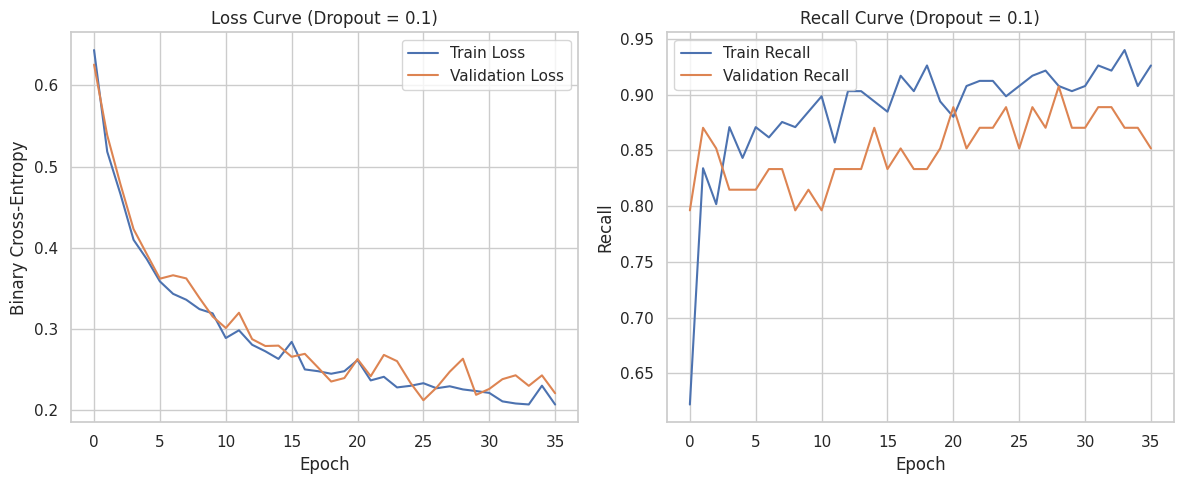

In [ ]:
# training curves
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12,5))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(history_df["loss"], label="Train Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy")
plt.title("Loss Curve (Dropout = 0.1)")
plt.legend()

# Recall Curve
plt.subplot(1,2,2)
plt.plot(history_df["recall"], label="Train Recall")
plt.plot(history_df["val_recall"], label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall Curve (Dropout = 0.1)")
plt.legend()

plt.tight_layout()
plt.show()


### 6.2. Threshold Selection Criterion

To determine an appropriate operating threshold, the F2-score is used as the optimization criterion. The F2-score places greater emphasis on recall than precision, reflecting the higher cost of missed failures relative to false alarms in predictive maintenance.

Unlike threshold-independent metrics such as ROC-AUC or PR-AUC, the F2-score directly evaluates the trade-off between recall and precision at a specific threshold, making it well suited for selecting an operational decision point.

Threshold optimization is performed exclusively on the validation set to avoid information leakage. The test set remains fully held out and is used only once for final evaluation.

### 6.3. Validation-Set Threshold Sweep

Predicted failure probabilities are generated for all validation samples using the selected model. A range of candidate thresholds is then evaluated, and for each threshold the following metrics are computed:
- Recall
- Precision
- F1-score
- F2-score

The threshold that maximizes the validation F2-score is selected as the final operating threshold. This approach ensures that the selected threshold balances sensitivity and false-alarm rate in a way that aligns with the project's operational priorities.

In [ ]:
# Predict probabilities on validation set
y_val_proba = final_model.predict(X_val).ravel()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# Threshold sweep
thresholds = np.linspace(0.01, 0.99, 99)
results = []

for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)

    results.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred, zero_division=0),
        "f1": fbeta_score(y_val, y_pred, beta=1, zero_division=0),
        "f2": fbeta_score(y_val, y_pred, beta=2, zero_division=0)
    })

threshold_df = pd.DataFrame(results)
threshold_df.head()



,threshold,precision,recall,f1,f2
0,0.01,0.047244,1.000000,0.090226,0.198675
1,0.02,0.054639,0.981481,0.103516,0.223440
2,0.03,0.060091,0.981481,0.113248,0.241348
3,0.04,0.064871,0.981481,0.121699,0.256534
4,0.05,0.070106,0.981481,0.130864,0.272634


In [ ]:
# Select threshold that maximizes F2
best_row = threshold_df.loc[threshold_df["f2"].idxmax()]
best_threshold = best_row["threshold"]

best_row, best_threshold

(threshold    0.870000
 precision    0.609375
 recall       0.722222
 f1           0.661017
 f2           0.696429
 Name: 86, dtype: float64,
 np.float64(0.87))

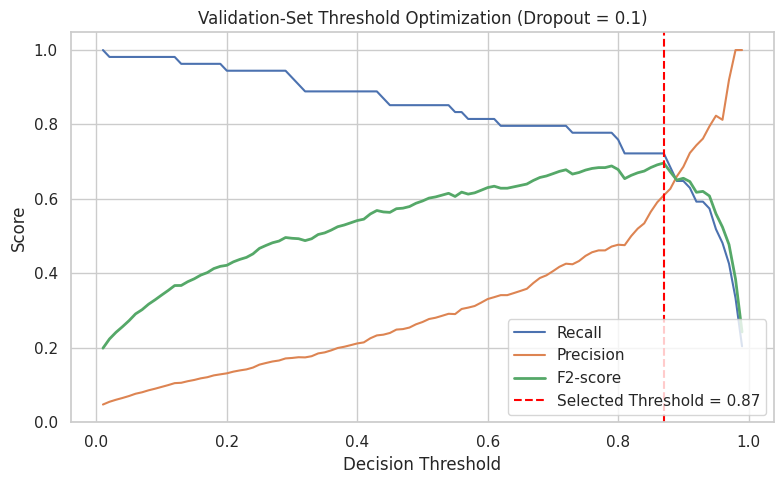

In [ ]:
# Threshold Trade-off Visualization
plt.figure(figsize=(8,5))
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["f2"], label="F2-score", linewidth=2)

plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Selected Threshold = {best_threshold:.2f}"
)

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Validation-Set Threshold Optimization (Dropout = 0.1)")
plt.legend()
plt.tight_layout()
plt.show()

### 6.4. Final Test Set Evaluation

In [ ]:
# Predict probabilities on test set
y_test_proba = final_model.predict(X_test_processed).ravel()

# Apply selected threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

test_results = {
    "recall": recall_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred, zero_division=0),
    "f1": fbeta_score(y_test, y_test_pred, beta=1),
    "f2": fbeta_score(y_test, y_test_pred, beta=2),
    "roc_auc": roc_auc_score(y_test, y_test_proba),
    "pr_auc": average_precision_score(y_test, y_test_proba)
}

test_results



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{'recall': 0.7058823529411765,
 'precision': 0.64,
 'f1': 0.6713286713286714,
 'f2': 0.69164265129683,
 'roc_auc': np.float64(0.9717223846060163),
 'pr_auc': np.float64(0.6827885658150068)}